In [2]:
import numpy as np

# -------------------------------------------------------------#
# Load data and proprocessing
# -------------------------------------------------------------#
data_URL = '/home/raychiu/Dataset/shakespeare_train.txt'
with open(data_URL, 'r') as f:
    text = f.read()

# Characters' collection
vocab = set(text)

# Construct character dictionary
vocab_to_int = {c: i for i, c in enumerate(vocab)}
int_to_vocab = dict(enumerate(vocab))

# Encode data, shape = [# of characters]
train_encode = np.array([vocab_to_int[c] for c in text], dtype=np.int32)
# -----------------------------------------------------------#
print(np.min(train_encode))
print(np.max(train_encode))
# -------------------------------------------------------------#
# Load data and proprocessing
# -------------------------------------------------------------#
data_URL = '/home/raychiu/Dataset/shakespeare_valid.txt'
with open(data_URL, 'r') as f:
    text = f.read()

# Characters' collection
#vocab = set(text)

# Construct character dictionary
#vocab_to_int = {c: i for i, c in enumerate(vocab)}
#int_to_vocab = dict(enumerate(vocab))

# Encode data, shape = [# of characters]
valid_encode = np.array([vocab_to_int[c] for c in text], dtype=np.int32)
# -----------------------------------------------------------#
print(np.min(valid_encode))
print(np.max(valid_encode))
# -------------------------------------------------------------#
# Divide data into mini-batches
# -------------------------------------------------------------#
def get_batches(arr, n_seqs, n_steps):
    
    '''
    arr: data to be divided
    n_seqs: batch-size, # of input sequences
    n_steps: timestep, # of characters in a input sequences
    '''
    
    batch_size = n_seqs * n_steps
    n_batches = int(len(arr) / batch_size)
    arr = arr[:batch_size * n_batches]
    arr = arr.reshape((n_seqs, -1))
    
    for n in range(0, arr.shape[1], n_steps):
        x = arr[:, n:n+n_steps]
        y = np.zeros_like(x)
        y[:, :-1], y[:, -1] = x[:, 1:], x[:, 0]
        yield x, y
        
def Onehot(num):
    num=num.flatten()
    num_sz=num.size
    output=np.zeros((num_sz,68))
    for i in range(num_sz):
        output[i,num[i]]=1

    return output

0
66
0
66


In [3]:
import torch.nn as nn
import torch.nn.functional as F
class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()
        #self.embedding=nn.Embedding(68,90)
        self.rnn=nn.LSTM(
            input_size=68,
            hidden_size=256,
            num_layers=1,
            batch_first=True,#x(batch_size,time_step,input)
        )
       # self.fc=nn.Linear(256,128)
        self.out=nn.Linear(256,68)
        
    def forward(self,x,h_state):
        #x(batch,time_step,input_sz)
        # h_n shape (n_layers, batch, hidden_size)
        # h_c shape (n_layers, batch, hidden_size)
        #r_out(batch,time_step,output_sz)
        r_out,(h_n,h_c)= self.rnn(x,h_state)
        h_state=(h_n,h_c)
        #r_out=self.fc(r_out_)
        outs=[]#保存所有時間點的預測值
        for time_step in range(r_out.size(1)):
            outs.append(self.out(r_out[:,time_step,:]))
        return torch.stack(outs,dim=1),h_state
#         outs=[]#保存所有時間點的預測值
#         for time_step in range(r_out.size(1)):
#             outs.append(self.out(r_out[:,time_step,:]))
#        return torch.stack(outs,dim=1),h_state
rnn=RNN()
rnn.cuda()
print(rnn)

RNN(
  (rnn): LSTM(68, 256, batch_first=True)
  (out): Linear(in_features=256, out_features=68, bias=True)
)


In [4]:
import torch.optim as optim
import torch
from torch.autograd import Variable
learning_rate=0.01
optimizer=optim.Adam(rnn.parameters(),lr=learning_rate)
loss_func=nn.CrossEntropyLoss( size_average=False)

In [5]:
input_sz=68
batch_size= 100
num_steps= 40
LOSS=[]
LOSS_=[]
for epoch in range(20):
    h_state=None
   # h_state_=None
   # loss=0
    tmp=[]
    for x, y in get_batches(train_encode, batch_size, num_steps):
#         x=Onehot(x)
#         x=x.reshape([batch_size,num_steps,input_sz])
        x_onehot = x.reshape([-1])
        x_onehot = (np.arange(68) == x_onehot[:,None]).astype(np.float32).reshape([batch_size,num_steps,68])
        b_x=Variable(torch.Tensor(x_onehot))
        b_y=Variable(torch.LongTensor(y))
        b_x=b_x.cuda()
        b_y=b_y.cuda()
        prediction,(h_state_n,h_state_c)=rnn(b_x,h_state)
        prediction=prediction.view(-1,68)
        h_state_n=Variable(h_state_n.data)
        h_state_n=h_state_n.cuda()
        h_state_c=Variable(h_state_c.data)
        h_state_c=h_state_c.cuda()
        h_state=(h_state_n,h_state_c)
        #print(prediction.data)
        b_y=b_y.view(-1)
        loss=loss_func(prediction,b_y)/(batch_size*num_steps) 
        optimizer.zero_grad()
        loss.backward()#retain_graph=True)
        optimizer.step()
        print('epoch:',epoch,'train','loss:',loss.data)
        tmp.append(loss.data.cpu().numpy())
    LOSS.append(np.mean(tmp))      
    h_state=None
    tmp=[]
    for x_, y_ in get_batches(valid_encode, batch_size, num_steps):
#         x_=Onehot(x_)
#         x_=x.reshape([batch_size,num_steps,input_sz])
#         b_x=Variable(torch.Tensor(x_))
        x_onehot = x_.reshape([-1])
        x_onehot = (np.arange(68) == x_onehot[:,None]).astype(np.float32).reshape([batch_size,num_steps,68])
        b_x=Variable(torch.Tensor(x_onehot))
        
        b_y=Variable(torch.LongTensor(y_))
        b_x=b_x.cuda()
        b_y=b_y.cuda()
        #optimizer.zero_grad()
        prediction,(h_state_n,h_state_c)=rnn(b_x,h_state)
        prediction=prediction.view(-1,68)
        h_state_n=Variable(h_state_n.data)
        h_state_n=h_state_n.cuda()
        h_state_c=Variable(h_state_c.data)
        h_state_c=h_state_c.cuda()
        h_state=(h_state_n,h_state_c)
        b_y=b_y.view(-1)
        loss=loss_func(prediction,b_y)/(batch_size*num_steps) 
        #loss_.backward(retain_graph=True)
        #optimizer.step()
        tmp.append(loss.data.cpu().numpy())
        print('epoch:',epoch,'valid','loss:',loss.data)
    LOSS_.append(np.mean(tmp))

epoch: 0 train loss: tensor(4.2147, device='cuda:0')
epoch: 0 train loss: tensor(4.0420, device='cuda:0')
epoch: 0 train loss: tensor(3.6926, device='cuda:0')
epoch: 0 train loss: tensor(3.3859, device='cuda:0')
epoch: 0 train loss: tensor(3.3644, device='cuda:0')
epoch: 0 train loss: tensor(3.3920, device='cuda:0')
epoch: 0 train loss: tensor(3.3979, device='cuda:0')
epoch: 0 train loss: tensor(3.3182, device='cuda:0')
epoch: 0 train loss: tensor(3.2934, device='cuda:0')
epoch: 0 train loss: tensor(3.3541, device='cuda:0')
epoch: 0 train loss: tensor(3.3202, device='cuda:0')
epoch: 0 train loss: tensor(3.3303, device='cuda:0')
epoch: 0 train loss: tensor(3.2972, device='cuda:0')
epoch: 0 train loss: tensor(3.2737, device='cuda:0')
epoch: 0 train loss: tensor(3.2354, device='cuda:0')
epoch: 0 train loss: tensor(3.2747, device='cuda:0')
epoch: 0 train loss: tensor(3.2755, device='cuda:0')
epoch: 0 train loss: tensor(3.2650, device='cuda:0')
epoch: 0 train loss: tensor(3.2758, device='cu

epoch: 0 train loss: tensor(2.1180, device='cuda:0')
epoch: 0 train loss: tensor(2.1128, device='cuda:0')
epoch: 0 train loss: tensor(2.1506, device='cuda:0')
epoch: 0 train loss: tensor(2.1308, device='cuda:0')
epoch: 0 train loss: tensor(2.1061, device='cuda:0')
epoch: 0 train loss: tensor(2.1134, device='cuda:0')
epoch: 0 train loss: tensor(2.0970, device='cuda:0')
epoch: 0 train loss: tensor(2.1133, device='cuda:0')
epoch: 0 train loss: tensor(2.1441, device='cuda:0')
epoch: 0 train loss: tensor(2.1236, device='cuda:0')
epoch: 0 train loss: tensor(2.0971, device='cuda:0')
epoch: 0 train loss: tensor(2.0981, device='cuda:0')
epoch: 0 train loss: tensor(2.1195, device='cuda:0')
epoch: 0 train loss: tensor(2.0980, device='cuda:0')
epoch: 0 train loss: tensor(2.1240, device='cuda:0')
epoch: 0 train loss: tensor(2.0817, device='cuda:0')
epoch: 0 train loss: tensor(2.0877, device='cuda:0')
epoch: 0 train loss: tensor(2.0836, device='cuda:0')
epoch: 0 train loss: tensor(2.0859, device='cu

epoch: 0 train loss: tensor(1.9230, device='cuda:0')
epoch: 0 train loss: tensor(1.8487, device='cuda:0')
epoch: 0 train loss: tensor(1.8470, device='cuda:0')
epoch: 0 train loss: tensor(1.8851, device='cuda:0')
epoch: 0 train loss: tensor(1.9060, device='cuda:0')
epoch: 0 train loss: tensor(1.8841, device='cuda:0')
epoch: 0 train loss: tensor(1.8673, device='cuda:0')
epoch: 0 train loss: tensor(1.8919, device='cuda:0')
epoch: 0 train loss: tensor(1.8809, device='cuda:0')
epoch: 0 train loss: tensor(1.8632, device='cuda:0')
epoch: 0 train loss: tensor(1.8739, device='cuda:0')
epoch: 0 train loss: tensor(1.8436, device='cuda:0')
epoch: 0 train loss: tensor(1.8553, device='cuda:0')
epoch: 0 train loss: tensor(1.8466, device='cuda:0')
epoch: 0 train loss: tensor(1.8668, device='cuda:0')
epoch: 0 train loss: tensor(1.8649, device='cuda:0')
epoch: 0 train loss: tensor(1.8356, device='cuda:0')
epoch: 0 train loss: tensor(1.8307, device='cuda:0')
epoch: 0 train loss: tensor(1.8698, device='cu

epoch: 0 train loss: tensor(1.7991, device='cuda:0')
epoch: 0 train loss: tensor(1.7522, device='cuda:0')
epoch: 0 train loss: tensor(1.7652, device='cuda:0')
epoch: 0 train loss: tensor(1.8118, device='cuda:0')
epoch: 0 train loss: tensor(1.7852, device='cuda:0')
epoch: 0 train loss: tensor(1.7715, device='cuda:0')
epoch: 0 train loss: tensor(1.7728, device='cuda:0')
epoch: 0 train loss: tensor(1.7617, device='cuda:0')
epoch: 0 train loss: tensor(1.7815, device='cuda:0')
epoch: 0 train loss: tensor(1.7923, device='cuda:0')
epoch: 0 train loss: tensor(1.7612, device='cuda:0')
epoch: 0 train loss: tensor(1.7410, device='cuda:0')
epoch: 0 train loss: tensor(1.8086, device='cuda:0')
epoch: 0 train loss: tensor(1.7647, device='cuda:0')
epoch: 0 train loss: tensor(1.7933, device='cuda:0')
epoch: 0 train loss: tensor(1.7131, device='cuda:0')
epoch: 0 train loss: tensor(1.7159, device='cuda:0')
epoch: 0 train loss: tensor(1.7601, device='cuda:0')
epoch: 0 train loss: tensor(1.7193, device='cu

epoch: 0 train loss: tensor(1.6893, device='cuda:0')
epoch: 0 train loss: tensor(1.7088, device='cuda:0')
epoch: 0 train loss: tensor(1.6963, device='cuda:0')
epoch: 0 train loss: tensor(1.7013, device='cuda:0')
epoch: 0 train loss: tensor(1.6568, device='cuda:0')
epoch: 0 train loss: tensor(1.7055, device='cuda:0')
epoch: 0 train loss: tensor(1.6092, device='cuda:0')
epoch: 0 train loss: tensor(1.7020, device='cuda:0')
epoch: 0 train loss: tensor(1.7055, device='cuda:0')
epoch: 0 train loss: tensor(1.7018, device='cuda:0')
epoch: 0 train loss: tensor(1.6440, device='cuda:0')
epoch: 0 train loss: tensor(1.6789, device='cuda:0')
epoch: 0 train loss: tensor(1.6805, device='cuda:0')
epoch: 0 train loss: tensor(1.6671, device='cuda:0')
epoch: 0 train loss: tensor(1.6974, device='cuda:0')
epoch: 0 train loss: tensor(1.6692, device='cuda:0')
epoch: 0 train loss: tensor(1.6875, device='cuda:0')
epoch: 0 train loss: tensor(1.6751, device='cuda:0')
epoch: 0 train loss: tensor(1.6856, device='cu

epoch: 0 train loss: tensor(1.6532, device='cuda:0')
epoch: 0 train loss: tensor(1.6487, device='cuda:0')
epoch: 0 train loss: tensor(1.6763, device='cuda:0')
epoch: 0 train loss: tensor(1.6428, device='cuda:0')
epoch: 0 train loss: tensor(1.6839, device='cuda:0')
epoch: 0 train loss: tensor(1.6202, device='cuda:0')
epoch: 0 train loss: tensor(1.6582, device='cuda:0')
epoch: 0 train loss: tensor(1.6666, device='cuda:0')
epoch: 0 train loss: tensor(1.6384, device='cuda:0')
epoch: 0 train loss: tensor(1.6378, device='cuda:0')
epoch: 0 train loss: tensor(1.6788, device='cuda:0')
epoch: 0 train loss: tensor(1.6793, device='cuda:0')
epoch: 0 train loss: tensor(1.6932, device='cuda:0')
epoch: 0 train loss: tensor(1.6244, device='cuda:0')
epoch: 0 train loss: tensor(1.6274, device='cuda:0')
epoch: 0 train loss: tensor(1.6491, device='cuda:0')
epoch: 0 train loss: tensor(1.6450, device='cuda:0')
epoch: 0 train loss: tensor(1.6680, device='cuda:0')
epoch: 0 train loss: tensor(1.6727, device='cu

epoch: 0 train loss: tensor(1.6395, device='cuda:0')
epoch: 0 train loss: tensor(1.5989, device='cuda:0')
epoch: 0 train loss: tensor(1.6124, device='cuda:0')
epoch: 0 train loss: tensor(1.6031, device='cuda:0')
epoch: 0 train loss: tensor(1.5863, device='cuda:0')
epoch: 0 train loss: tensor(1.6385, device='cuda:0')
epoch: 0 train loss: tensor(1.5993, device='cuda:0')
epoch: 0 train loss: tensor(1.5941, device='cuda:0')
epoch: 0 train loss: tensor(1.6174, device='cuda:0')
epoch: 0 train loss: tensor(1.5768, device='cuda:0')
epoch: 0 train loss: tensor(1.6311, device='cuda:0')
epoch: 0 train loss: tensor(1.6149, device='cuda:0')
epoch: 0 train loss: tensor(1.6040, device='cuda:0')
epoch: 0 train loss: tensor(1.6274, device='cuda:0')
epoch: 0 train loss: tensor(1.6145, device='cuda:0')
epoch: 0 train loss: tensor(1.6087, device='cuda:0')
epoch: 0 train loss: tensor(1.5851, device='cuda:0')
epoch: 0 train loss: tensor(1.5723, device='cuda:0')
epoch: 0 train loss: tensor(1.6523, device='cu

epoch: 0 valid loss: tensor(1.7089, device='cuda:0')
epoch: 0 valid loss: tensor(1.7354, device='cuda:0')
epoch: 0 valid loss: tensor(1.7058, device='cuda:0')
epoch: 0 valid loss: tensor(1.6871, device='cuda:0')
epoch: 0 valid loss: tensor(1.7574, device='cuda:0')
epoch: 0 valid loss: tensor(1.7130, device='cuda:0')
epoch: 0 valid loss: tensor(1.7589, device='cuda:0')
epoch: 0 valid loss: tensor(1.7351, device='cuda:0')
epoch: 0 valid loss: tensor(1.7003, device='cuda:0')
epoch: 0 valid loss: tensor(1.7201, device='cuda:0')
epoch: 0 valid loss: tensor(1.7379, device='cuda:0')
epoch: 0 valid loss: tensor(1.6869, device='cuda:0')
epoch: 0 valid loss: tensor(1.7038, device='cuda:0')
epoch: 0 valid loss: tensor(1.7172, device='cuda:0')
epoch: 0 valid loss: tensor(1.6756, device='cuda:0')
epoch: 0 valid loss: tensor(1.7225, device='cuda:0')
epoch: 0 valid loss: tensor(1.7933, device='cuda:0')
epoch: 0 valid loss: tensor(1.7038, device='cuda:0')
epoch: 0 valid loss: tensor(1.6981, device='cu

epoch: 1 train loss: tensor(1.6442, device='cuda:0')
epoch: 1 train loss: tensor(1.5984, device='cuda:0')
epoch: 1 train loss: tensor(1.5907, device='cuda:0')
epoch: 1 train loss: tensor(1.5769, device='cuda:0')
epoch: 1 train loss: tensor(1.5482, device='cuda:0')
epoch: 1 train loss: tensor(1.5440, device='cuda:0')
epoch: 1 train loss: tensor(1.5795, device='cuda:0')
epoch: 1 train loss: tensor(1.5432, device='cuda:0')
epoch: 1 train loss: tensor(1.5410, device='cuda:0')
epoch: 1 train loss: tensor(1.5569, device='cuda:0')
epoch: 1 train loss: tensor(1.5762, device='cuda:0')
epoch: 1 train loss: tensor(1.5528, device='cuda:0')
epoch: 1 train loss: tensor(1.5747, device='cuda:0')
epoch: 1 train loss: tensor(1.5371, device='cuda:0')
epoch: 1 train loss: tensor(1.5374, device='cuda:0')
epoch: 1 train loss: tensor(1.5583, device='cuda:0')
epoch: 1 train loss: tensor(1.5791, device='cuda:0')
epoch: 1 train loss: tensor(1.5500, device='cuda:0')
epoch: 1 train loss: tensor(1.5691, device='cu

epoch: 1 train loss: tensor(1.5538, device='cuda:0')
epoch: 1 train loss: tensor(1.6142, device='cuda:0')
epoch: 1 train loss: tensor(1.5460, device='cuda:0')
epoch: 1 train loss: tensor(1.5447, device='cuda:0')
epoch: 1 train loss: tensor(1.5918, device='cuda:0')
epoch: 1 train loss: tensor(1.5597, device='cuda:0')
epoch: 1 train loss: tensor(1.5485, device='cuda:0')
epoch: 1 train loss: tensor(1.5571, device='cuda:0')
epoch: 1 train loss: tensor(1.5968, device='cuda:0')
epoch: 1 train loss: tensor(1.5550, device='cuda:0')
epoch: 1 train loss: tensor(1.5386, device='cuda:0')
epoch: 1 train loss: tensor(1.5470, device='cuda:0')
epoch: 1 train loss: tensor(1.5021, device='cuda:0')
epoch: 1 train loss: tensor(1.5150, device='cuda:0')
epoch: 1 train loss: tensor(1.5347, device='cuda:0')
epoch: 1 train loss: tensor(1.5199, device='cuda:0')
epoch: 1 train loss: tensor(1.5725, device='cuda:0')
epoch: 1 train loss: tensor(1.5414, device='cuda:0')
epoch: 1 train loss: tensor(1.5340, device='cu

epoch: 1 train loss: tensor(1.5255, device='cuda:0')
epoch: 1 train loss: tensor(1.5097, device='cuda:0')
epoch: 1 train loss: tensor(1.5281, device='cuda:0')
epoch: 1 train loss: tensor(1.5327, device='cuda:0')
epoch: 1 train loss: tensor(1.5450, device='cuda:0')
epoch: 1 train loss: tensor(1.5250, device='cuda:0')
epoch: 1 train loss: tensor(1.5306, device='cuda:0')
epoch: 1 train loss: tensor(1.5449, device='cuda:0')
epoch: 1 train loss: tensor(1.5734, device='cuda:0')
epoch: 1 train loss: tensor(1.5632, device='cuda:0')
epoch: 1 train loss: tensor(1.5566, device='cuda:0')
epoch: 1 train loss: tensor(1.5214, device='cuda:0')
epoch: 1 train loss: tensor(1.5808, device='cuda:0')
epoch: 1 train loss: tensor(1.5549, device='cuda:0')
epoch: 1 train loss: tensor(1.5560, device='cuda:0')
epoch: 1 train loss: tensor(1.5501, device='cuda:0')
epoch: 1 train loss: tensor(1.5833, device='cuda:0')
epoch: 1 train loss: tensor(1.5638, device='cuda:0')
epoch: 1 train loss: tensor(1.5533, device='cu

epoch: 1 train loss: tensor(1.5095, device='cuda:0')
epoch: 1 train loss: tensor(1.5605, device='cuda:0')
epoch: 1 train loss: tensor(1.5193, device='cuda:0')
epoch: 1 train loss: tensor(1.4923, device='cuda:0')
epoch: 1 train loss: tensor(1.5154, device='cuda:0')
epoch: 1 train loss: tensor(1.4652, device='cuda:0')
epoch: 1 train loss: tensor(1.4923, device='cuda:0')
epoch: 1 train loss: tensor(1.5332, device='cuda:0')
epoch: 1 train loss: tensor(1.5760, device='cuda:0')
epoch: 1 train loss: tensor(1.5005, device='cuda:0')
epoch: 1 train loss: tensor(1.4944, device='cuda:0')
epoch: 1 train loss: tensor(1.4947, device='cuda:0')
epoch: 1 train loss: tensor(1.5232, device='cuda:0')
epoch: 1 train loss: tensor(1.4885, device='cuda:0')
epoch: 1 train loss: tensor(1.5051, device='cuda:0')
epoch: 1 train loss: tensor(1.4926, device='cuda:0')
epoch: 1 train loss: tensor(1.5444, device='cuda:0')
epoch: 1 train loss: tensor(1.5221, device='cuda:0')
epoch: 1 train loss: tensor(1.5094, device='cu

epoch: 1 train loss: tensor(1.5150, device='cuda:0')
epoch: 1 train loss: tensor(1.5265, device='cuda:0')
epoch: 1 train loss: tensor(1.5371, device='cuda:0')
epoch: 1 train loss: tensor(1.5373, device='cuda:0')
epoch: 1 train loss: tensor(1.5258, device='cuda:0')
epoch: 1 train loss: tensor(1.4863, device='cuda:0')
epoch: 1 train loss: tensor(1.5347, device='cuda:0')
epoch: 1 train loss: tensor(1.5455, device='cuda:0')
epoch: 1 train loss: tensor(1.5191, device='cuda:0')
epoch: 1 train loss: tensor(1.5391, device='cuda:0')
epoch: 1 train loss: tensor(1.5332, device='cuda:0')
epoch: 1 train loss: tensor(1.5232, device='cuda:0')
epoch: 1 train loss: tensor(1.5226, device='cuda:0')
epoch: 1 train loss: tensor(1.5330, device='cuda:0')
epoch: 1 train loss: tensor(1.5245, device='cuda:0')
epoch: 1 train loss: tensor(1.5480, device='cuda:0')
epoch: 1 train loss: tensor(1.5791, device='cuda:0')
epoch: 1 train loss: tensor(1.5310, device='cuda:0')
epoch: 1 train loss: tensor(1.4852, device='cu

epoch: 1 train loss: tensor(1.4995, device='cuda:0')
epoch: 1 train loss: tensor(1.5097, device='cuda:0')
epoch: 1 train loss: tensor(1.5401, device='cuda:0')
epoch: 1 train loss: tensor(1.4959, device='cuda:0')
epoch: 1 train loss: tensor(1.5192, device='cuda:0')
epoch: 1 train loss: tensor(1.4528, device='cuda:0')
epoch: 1 train loss: tensor(1.5233, device='cuda:0')
epoch: 1 train loss: tensor(1.4928, device='cuda:0')
epoch: 1 train loss: tensor(1.5184, device='cuda:0')
epoch: 1 train loss: tensor(1.4705, device='cuda:0')
epoch: 1 train loss: tensor(1.5173, device='cuda:0')
epoch: 1 train loss: tensor(1.5423, device='cuda:0')
epoch: 1 train loss: tensor(1.5036, device='cuda:0')
epoch: 1 train loss: tensor(1.4847, device='cuda:0')
epoch: 1 train loss: tensor(1.5303, device='cuda:0')
epoch: 1 train loss: tensor(1.5306, device='cuda:0')
epoch: 1 train loss: tensor(1.5139, device='cuda:0')
epoch: 1 train loss: tensor(1.5450, device='cuda:0')
epoch: 1 train loss: tensor(1.4886, device='cu

epoch: 1 train loss: tensor(1.5342, device='cuda:0')
epoch: 1 train loss: tensor(1.5372, device='cuda:0')
epoch: 1 train loss: tensor(1.4886, device='cuda:0')
epoch: 1 train loss: tensor(1.5052, device='cuda:0')
epoch: 1 train loss: tensor(1.5189, device='cuda:0')
epoch: 1 train loss: tensor(1.5171, device='cuda:0')
epoch: 1 train loss: tensor(1.5362, device='cuda:0')
epoch: 1 train loss: tensor(1.5364, device='cuda:0')
epoch: 1 train loss: tensor(1.5486, device='cuda:0')
epoch: 1 train loss: tensor(1.5333, device='cuda:0')
epoch: 1 train loss: tensor(1.5587, device='cuda:0')
epoch: 1 train loss: tensor(1.5364, device='cuda:0')
epoch: 1 train loss: tensor(1.4906, device='cuda:0')
epoch: 1 train loss: tensor(1.5374, device='cuda:0')
epoch: 1 train loss: tensor(1.5078, device='cuda:0')
epoch: 1 train loss: tensor(1.5028, device='cuda:0')
epoch: 1 train loss: tensor(1.5313, device='cuda:0')
epoch: 1 train loss: tensor(1.4789, device='cuda:0')
epoch: 1 train loss: tensor(1.5112, device='cu

epoch: 2 train loss: tensor(1.5314, device='cuda:0')
epoch: 2 train loss: tensor(1.5180, device='cuda:0')
epoch: 2 train loss: tensor(1.5113, device='cuda:0')
epoch: 2 train loss: tensor(1.4825, device='cuda:0')
epoch: 2 train loss: tensor(1.5049, device='cuda:0')
epoch: 2 train loss: tensor(1.5232, device='cuda:0')
epoch: 2 train loss: tensor(1.5161, device='cuda:0')
epoch: 2 train loss: tensor(1.4804, device='cuda:0')
epoch: 2 train loss: tensor(1.4964, device='cuda:0')
epoch: 2 train loss: tensor(1.5021, device='cuda:0')
epoch: 2 train loss: tensor(1.4440, device='cuda:0')
epoch: 2 train loss: tensor(1.5510, device='cuda:0')
epoch: 2 train loss: tensor(1.4759, device='cuda:0')
epoch: 2 train loss: tensor(1.4639, device='cuda:0')
epoch: 2 train loss: tensor(1.4768, device='cuda:0')
epoch: 2 train loss: tensor(1.4861, device='cuda:0')
epoch: 2 train loss: tensor(1.4462, device='cuda:0')
epoch: 2 train loss: tensor(1.4953, device='cuda:0')
epoch: 2 train loss: tensor(1.5136, device='cu

epoch: 2 train loss: tensor(1.5254, device='cuda:0')
epoch: 2 train loss: tensor(1.5041, device='cuda:0')
epoch: 2 train loss: tensor(1.5002, device='cuda:0')
epoch: 2 train loss: tensor(1.4771, device='cuda:0')
epoch: 2 train loss: tensor(1.5052, device='cuda:0')
epoch: 2 train loss: tensor(1.5132, device='cuda:0')
epoch: 2 train loss: tensor(1.5243, device='cuda:0')
epoch: 2 train loss: tensor(1.4929, device='cuda:0')
epoch: 2 train loss: tensor(1.4909, device='cuda:0')
epoch: 2 train loss: tensor(1.5159, device='cuda:0')
epoch: 2 train loss: tensor(1.4777, device='cuda:0')
epoch: 2 train loss: tensor(1.5046, device='cuda:0')
epoch: 2 train loss: tensor(1.4825, device='cuda:0')
epoch: 2 train loss: tensor(1.5195, device='cuda:0')
epoch: 2 train loss: tensor(1.5156, device='cuda:0')
epoch: 2 train loss: tensor(1.4774, device='cuda:0')
epoch: 2 train loss: tensor(1.4805, device='cuda:0')
epoch: 2 train loss: tensor(1.4586, device='cuda:0')
epoch: 2 train loss: tensor(1.4883, device='cu

epoch: 2 train loss: tensor(1.4970, device='cuda:0')
epoch: 2 train loss: tensor(1.4512, device='cuda:0')
epoch: 2 train loss: tensor(1.5043, device='cuda:0')
epoch: 2 train loss: tensor(1.4870, device='cuda:0')
epoch: 2 train loss: tensor(1.4694, device='cuda:0')
epoch: 2 train loss: tensor(1.4805, device='cuda:0')
epoch: 2 train loss: tensor(1.4819, device='cuda:0')
epoch: 2 train loss: tensor(1.4725, device='cuda:0')
epoch: 2 train loss: tensor(1.4696, device='cuda:0')
epoch: 2 train loss: tensor(1.4790, device='cuda:0')
epoch: 2 train loss: tensor(1.4955, device='cuda:0')
epoch: 2 train loss: tensor(1.4796, device='cuda:0')
epoch: 2 train loss: tensor(1.4678, device='cuda:0')
epoch: 2 train loss: tensor(1.4548, device='cuda:0')
epoch: 2 train loss: tensor(1.4812, device='cuda:0')
epoch: 2 train loss: tensor(1.4842, device='cuda:0')
epoch: 2 train loss: tensor(1.4868, device='cuda:0')
epoch: 2 train loss: tensor(1.4763, device='cuda:0')
epoch: 2 train loss: tensor(1.4967, device='cu

epoch: 2 train loss: tensor(1.4610, device='cuda:0')
epoch: 2 train loss: tensor(1.4274, device='cuda:0')
epoch: 2 train loss: tensor(1.4937, device='cuda:0')
epoch: 2 train loss: tensor(1.4525, device='cuda:0')
epoch: 2 train loss: tensor(1.4520, device='cuda:0')
epoch: 2 train loss: tensor(1.4595, device='cuda:0')
epoch: 2 train loss: tensor(1.4919, device='cuda:0')
epoch: 2 train loss: tensor(1.4569, device='cuda:0')
epoch: 2 train loss: tensor(1.4676, device='cuda:0')
epoch: 2 train loss: tensor(1.4788, device='cuda:0')
epoch: 2 train loss: tensor(1.4362, device='cuda:0')
epoch: 2 train loss: tensor(1.4146, device='cuda:0')
epoch: 2 train loss: tensor(1.4818, device='cuda:0')
epoch: 2 train loss: tensor(1.4745, device='cuda:0')
epoch: 2 train loss: tensor(1.4903, device='cuda:0')
epoch: 2 train loss: tensor(1.4391, device='cuda:0')
epoch: 2 train loss: tensor(1.5270, device='cuda:0')
epoch: 2 train loss: tensor(1.5125, device='cuda:0')
epoch: 2 train loss: tensor(1.4689, device='cu

epoch: 2 train loss: tensor(1.4734, device='cuda:0')
epoch: 2 train loss: tensor(1.4767, device='cuda:0')
epoch: 2 train loss: tensor(1.5025, device='cuda:0')
epoch: 2 train loss: tensor(1.4466, device='cuda:0')
epoch: 2 train loss: tensor(1.4907, device='cuda:0')
epoch: 2 train loss: tensor(1.4530, device='cuda:0')
epoch: 2 train loss: tensor(1.4962, device='cuda:0')
epoch: 2 train loss: tensor(1.4470, device='cuda:0')
epoch: 2 train loss: tensor(1.5043, device='cuda:0')
epoch: 2 train loss: tensor(1.4964, device='cuda:0')
epoch: 2 train loss: tensor(1.4833, device='cuda:0')
epoch: 2 train loss: tensor(1.4257, device='cuda:0')
epoch: 2 train loss: tensor(1.4925, device='cuda:0')
epoch: 2 train loss: tensor(1.4244, device='cuda:0')
epoch: 2 train loss: tensor(1.4353, device='cuda:0')
epoch: 2 train loss: tensor(1.4849, device='cuda:0')
epoch: 2 train loss: tensor(1.5014, device='cuda:0')
epoch: 2 train loss: tensor(1.4805, device='cuda:0')
epoch: 2 train loss: tensor(1.5114, device='cu

epoch: 2 train loss: tensor(1.4261, device='cuda:0')
epoch: 2 train loss: tensor(1.4309, device='cuda:0')
epoch: 2 train loss: tensor(1.4497, device='cuda:0')
epoch: 2 train loss: tensor(1.4801, device='cuda:0')
epoch: 2 train loss: tensor(1.5014, device='cuda:0')
epoch: 2 train loss: tensor(1.4317, device='cuda:0')
epoch: 2 train loss: tensor(1.4689, device='cuda:0')
epoch: 2 train loss: tensor(1.4639, device='cuda:0')
epoch: 2 train loss: tensor(1.4680, device='cuda:0')
epoch: 2 train loss: tensor(1.4534, device='cuda:0')
epoch: 2 train loss: tensor(1.4524, device='cuda:0')
epoch: 2 train loss: tensor(1.4503, device='cuda:0')
epoch: 2 train loss: tensor(1.4635, device='cuda:0')
epoch: 2 train loss: tensor(1.4735, device='cuda:0')
epoch: 2 train loss: tensor(1.4679, device='cuda:0')
epoch: 2 train loss: tensor(1.4544, device='cuda:0')
epoch: 2 train loss: tensor(1.4670, device='cuda:0')
epoch: 2 train loss: tensor(1.4712, device='cuda:0')
epoch: 2 train loss: tensor(1.4868, device='cu

epoch: 2 train loss: tensor(1.5098, device='cuda:0')
epoch: 2 train loss: tensor(1.4440, device='cuda:0')
epoch: 2 train loss: tensor(1.4924, device='cuda:0')
epoch: 2 train loss: tensor(1.4407, device='cuda:0')
epoch: 2 train loss: tensor(1.4891, device='cuda:0')
epoch: 2 train loss: tensor(1.4923, device='cuda:0')
epoch: 2 train loss: tensor(1.5242, device='cuda:0')
epoch: 2 train loss: tensor(1.5481, device='cuda:0')
epoch: 2 train loss: tensor(1.4825, device='cuda:0')
epoch: 2 train loss: tensor(1.5626, device='cuda:0')
epoch: 2 train loss: tensor(1.4734, device='cuda:0')
epoch: 2 train loss: tensor(1.4681, device='cuda:0')
epoch: 2 train loss: tensor(1.4580, device='cuda:0')
epoch: 2 train loss: tensor(1.4373, device='cuda:0')
epoch: 2 train loss: tensor(1.5068, device='cuda:0')
epoch: 2 train loss: tensor(1.4768, device='cuda:0')
epoch: 2 train loss: tensor(1.5067, device='cuda:0')
epoch: 2 train loss: tensor(1.4736, device='cuda:0')
epoch: 2 train loss: tensor(1.4958, device='cu

epoch: 3 train loss: tensor(1.4689, device='cuda:0')
epoch: 3 train loss: tensor(1.4719, device='cuda:0')
epoch: 3 train loss: tensor(1.4807, device='cuda:0')
epoch: 3 train loss: tensor(1.4600, device='cuda:0')
epoch: 3 train loss: tensor(1.4993, device='cuda:0')
epoch: 3 train loss: tensor(1.4839, device='cuda:0')
epoch: 3 train loss: tensor(1.4307, device='cuda:0')
epoch: 3 train loss: tensor(1.4448, device='cuda:0')
epoch: 3 train loss: tensor(1.4606, device='cuda:0')
epoch: 3 train loss: tensor(1.5079, device='cuda:0')
epoch: 3 train loss: tensor(1.4896, device='cuda:0')
epoch: 3 train loss: tensor(1.4473, device='cuda:0')
epoch: 3 train loss: tensor(1.4818, device='cuda:0')
epoch: 3 train loss: tensor(1.4703, device='cuda:0')
epoch: 3 train loss: tensor(1.4469, device='cuda:0')
epoch: 3 train loss: tensor(1.5080, device='cuda:0')
epoch: 3 train loss: tensor(1.5167, device='cuda:0')
epoch: 3 train loss: tensor(1.4639, device='cuda:0')
epoch: 3 train loss: tensor(1.4314, device='cu

epoch: 3 train loss: tensor(1.4437, device='cuda:0')
epoch: 3 train loss: tensor(1.4299, device='cuda:0')
epoch: 3 train loss: tensor(1.4472, device='cuda:0')
epoch: 3 train loss: tensor(1.4738, device='cuda:0')
epoch: 3 train loss: tensor(1.4501, device='cuda:0')
epoch: 3 train loss: tensor(1.4607, device='cuda:0')
epoch: 3 train loss: tensor(1.4829, device='cuda:0')
epoch: 3 train loss: tensor(1.4428, device='cuda:0')
epoch: 3 train loss: tensor(1.4613, device='cuda:0')
epoch: 3 train loss: tensor(1.4821, device='cuda:0')
epoch: 3 train loss: tensor(1.4666, device='cuda:0')
epoch: 3 train loss: tensor(1.5002, device='cuda:0')
epoch: 3 train loss: tensor(1.4737, device='cuda:0')
epoch: 3 train loss: tensor(1.4469, device='cuda:0')
epoch: 3 train loss: tensor(1.4536, device='cuda:0')
epoch: 3 train loss: tensor(1.4466, device='cuda:0')
epoch: 3 train loss: tensor(1.4588, device='cuda:0')
epoch: 3 train loss: tensor(1.4284, device='cuda:0')
epoch: 3 train loss: tensor(1.4606, device='cu

epoch: 3 train loss: tensor(1.4895, device='cuda:0')
epoch: 3 train loss: tensor(1.4778, device='cuda:0')
epoch: 3 train loss: tensor(1.4378, device='cuda:0')
epoch: 3 train loss: tensor(1.4823, device='cuda:0')
epoch: 3 train loss: tensor(1.4802, device='cuda:0')
epoch: 3 train loss: tensor(1.4526, device='cuda:0')
epoch: 3 train loss: tensor(1.4534, device='cuda:0')
epoch: 3 train loss: tensor(1.4243, device='cuda:0')
epoch: 3 train loss: tensor(1.4250, device='cuda:0')
epoch: 3 train loss: tensor(1.4458, device='cuda:0')
epoch: 3 train loss: tensor(1.4754, device='cuda:0')
epoch: 3 train loss: tensor(1.4560, device='cuda:0')
epoch: 3 train loss: tensor(1.4454, device='cuda:0')
epoch: 3 train loss: tensor(1.4423, device='cuda:0')
epoch: 3 train loss: tensor(1.4759, device='cuda:0')
epoch: 3 train loss: tensor(1.5122, device='cuda:0')
epoch: 3 train loss: tensor(1.4933, device='cuda:0')
epoch: 3 train loss: tensor(1.4743, device='cuda:0')
epoch: 3 train loss: tensor(1.4518, device='cu

epoch: 3 train loss: tensor(1.4797, device='cuda:0')
epoch: 3 train loss: tensor(1.4735, device='cuda:0')
epoch: 3 train loss: tensor(1.4810, device='cuda:0')
epoch: 3 train loss: tensor(1.4501, device='cuda:0')
epoch: 3 train loss: tensor(1.4623, device='cuda:0')
epoch: 3 train loss: tensor(1.4628, device='cuda:0')
epoch: 3 train loss: tensor(1.4331, device='cuda:0')
epoch: 3 train loss: tensor(1.4345, device='cuda:0')
epoch: 3 train loss: tensor(1.5017, device='cuda:0')
epoch: 3 train loss: tensor(1.4655, device='cuda:0')
epoch: 3 train loss: tensor(1.4979, device='cuda:0')
epoch: 3 train loss: tensor(1.4150, device='cuda:0')
epoch: 3 train loss: tensor(1.4238, device='cuda:0')
epoch: 3 train loss: tensor(1.4952, device='cuda:0')
epoch: 3 train loss: tensor(1.4570, device='cuda:0')
epoch: 3 train loss: tensor(1.4380, device='cuda:0')
epoch: 3 train loss: tensor(1.4416, device='cuda:0')
epoch: 3 train loss: tensor(1.4961, device='cuda:0')
epoch: 3 train loss: tensor(1.4896, device='cu

epoch: 3 train loss: tensor(1.4149, device='cuda:0')
epoch: 3 train loss: tensor(1.4809, device='cuda:0')
epoch: 3 train loss: tensor(1.3791, device='cuda:0')
epoch: 3 train loss: tensor(1.4585, device='cuda:0')
epoch: 3 train loss: tensor(1.4559, device='cuda:0')
epoch: 3 train loss: tensor(1.4474, device='cuda:0')
epoch: 3 train loss: tensor(1.3970, device='cuda:0')
epoch: 3 train loss: tensor(1.4412, device='cuda:0')
epoch: 3 train loss: tensor(1.4393, device='cuda:0')
epoch: 3 train loss: tensor(1.4301, device='cuda:0')
epoch: 3 train loss: tensor(1.4442, device='cuda:0')
epoch: 3 train loss: tensor(1.4388, device='cuda:0')
epoch: 3 train loss: tensor(1.4622, device='cuda:0')
epoch: 3 train loss: tensor(1.4212, device='cuda:0')
epoch: 3 train loss: tensor(1.4495, device='cuda:0')
epoch: 3 train loss: tensor(1.4220, device='cuda:0')
epoch: 3 train loss: tensor(1.4093, device='cuda:0')
epoch: 3 train loss: tensor(1.4542, device='cuda:0')
epoch: 3 train loss: tensor(1.4157, device='cu

epoch: 3 train loss: tensor(1.4953, device='cuda:0')
epoch: 3 train loss: tensor(1.4246, device='cuda:0')
epoch: 3 train loss: tensor(1.4878, device='cuda:0')
epoch: 3 train loss: tensor(1.4937, device='cuda:0')
epoch: 3 train loss: tensor(1.4386, device='cuda:0')
epoch: 3 train loss: tensor(1.4385, device='cuda:0')
epoch: 3 train loss: tensor(1.4941, device='cuda:0')
epoch: 3 train loss: tensor(1.4672, device='cuda:0')
epoch: 3 train loss: tensor(1.4985, device='cuda:0')
epoch: 3 train loss: tensor(1.4537, device='cuda:0')
epoch: 3 train loss: tensor(1.4580, device='cuda:0')
epoch: 3 train loss: tensor(1.4728, device='cuda:0')
epoch: 3 train loss: tensor(1.4579, device='cuda:0')
epoch: 3 train loss: tensor(1.4634, device='cuda:0')
epoch: 3 train loss: tensor(1.4557, device='cuda:0')
epoch: 3 train loss: tensor(1.4805, device='cuda:0')
epoch: 3 train loss: tensor(1.4309, device='cuda:0')
epoch: 3 train loss: tensor(1.4410, device='cuda:0')
epoch: 3 train loss: tensor(1.4327, device='cu

epoch: 3 train loss: tensor(1.4421, device='cuda:0')
epoch: 3 train loss: tensor(1.4884, device='cuda:0')
epoch: 3 train loss: tensor(1.4729, device='cuda:0')
epoch: 3 train loss: tensor(1.4496, device='cuda:0')
epoch: 3 train loss: tensor(1.4682, device='cuda:0')
epoch: 3 train loss: tensor(1.4246, device='cuda:0')
epoch: 3 train loss: tensor(1.4642, device='cuda:0')
epoch: 3 train loss: tensor(1.4552, device='cuda:0')
epoch: 3 train loss: tensor(1.4428, device='cuda:0')
epoch: 3 train loss: tensor(1.4830, device='cuda:0')
epoch: 3 train loss: tensor(1.4512, device='cuda:0')
epoch: 3 train loss: tensor(1.4565, device='cuda:0')
epoch: 3 train loss: tensor(1.4482, device='cuda:0')
epoch: 3 train loss: tensor(1.4491, device='cuda:0')
epoch: 3 train loss: tensor(1.4841, device='cuda:0')
epoch: 3 train loss: tensor(1.4658, device='cuda:0')
epoch: 3 train loss: tensor(1.4435, device='cuda:0')
epoch: 3 train loss: tensor(1.4756, device='cuda:0')
epoch: 3 train loss: tensor(1.4615, device='cu

epoch: 3 valid loss: tensor(1.5891, device='cuda:0')
epoch: 3 valid loss: tensor(1.6131, device='cuda:0')
epoch: 3 valid loss: tensor(1.6992, device='cuda:0')
epoch: 3 valid loss: tensor(1.5998, device='cuda:0')
epoch: 3 valid loss: tensor(1.5916, device='cuda:0')
epoch: 3 valid loss: tensor(1.6180, device='cuda:0')
epoch: 3 valid loss: tensor(1.5687, device='cuda:0')
epoch: 3 valid loss: tensor(1.5891, device='cuda:0')
epoch: 3 valid loss: tensor(1.5802, device='cuda:0')
epoch: 3 valid loss: tensor(1.5597, device='cuda:0')
epoch: 3 valid loss: tensor(1.6162, device='cuda:0')
epoch: 3 valid loss: tensor(1.5635, device='cuda:0')
epoch: 3 valid loss: tensor(1.5925, device='cuda:0')
epoch: 3 valid loss: tensor(1.6582, device='cuda:0')
epoch: 3 valid loss: tensor(1.5474, device='cuda:0')
epoch: 3 valid loss: tensor(1.6506, device='cuda:0')
epoch: 3 valid loss: tensor(1.6198, device='cuda:0')
epoch: 3 valid loss: tensor(1.6231, device='cuda:0')
epoch: 3 valid loss: tensor(1.5486, device='cu

epoch: 4 train loss: tensor(1.4394, device='cuda:0')
epoch: 4 train loss: tensor(1.4431, device='cuda:0')
epoch: 4 train loss: tensor(1.4353, device='cuda:0')
epoch: 4 train loss: tensor(1.4515, device='cuda:0')
epoch: 4 train loss: tensor(1.4694, device='cuda:0')
epoch: 4 train loss: tensor(1.4078, device='cuda:0')
epoch: 4 train loss: tensor(1.4524, device='cuda:0')
epoch: 4 train loss: tensor(1.4430, device='cuda:0')
epoch: 4 train loss: tensor(1.4350, device='cuda:0')
epoch: 4 train loss: tensor(1.4000, device='cuda:0')
epoch: 4 train loss: tensor(1.4813, device='cuda:0')
epoch: 4 train loss: tensor(1.4380, device='cuda:0')
epoch: 4 train loss: tensor(1.4309, device='cuda:0')
epoch: 4 train loss: tensor(1.4472, device='cuda:0')
epoch: 4 train loss: tensor(1.4489, device='cuda:0')
epoch: 4 train loss: tensor(1.4392, device='cuda:0')
epoch: 4 train loss: tensor(1.4274, device='cuda:0')
epoch: 4 train loss: tensor(1.4227, device='cuda:0')
epoch: 4 train loss: tensor(1.4225, device='cu

epoch: 4 train loss: tensor(1.4323, device='cuda:0')
epoch: 4 train loss: tensor(1.4046, device='cuda:0')
epoch: 4 train loss: tensor(1.4507, device='cuda:0')
epoch: 4 train loss: tensor(1.4234, device='cuda:0')
epoch: 4 train loss: tensor(1.4340, device='cuda:0')
epoch: 4 train loss: tensor(1.4348, device='cuda:0')
epoch: 4 train loss: tensor(1.4805, device='cuda:0')
epoch: 4 train loss: tensor(1.4047, device='cuda:0')
epoch: 4 train loss: tensor(1.4219, device='cuda:0')
epoch: 4 train loss: tensor(1.4317, device='cuda:0')
epoch: 4 train loss: tensor(1.4731, device='cuda:0')
epoch: 4 train loss: tensor(1.4534, device='cuda:0')
epoch: 4 train loss: tensor(1.4279, device='cuda:0')
epoch: 4 train loss: tensor(1.4407, device='cuda:0')
epoch: 4 train loss: tensor(1.4171, device='cuda:0')
epoch: 4 train loss: tensor(1.4287, device='cuda:0')
epoch: 4 train loss: tensor(1.4322, device='cuda:0')
epoch: 4 train loss: tensor(1.4231, device='cuda:0')
epoch: 4 train loss: tensor(1.3919, device='cu

epoch: 4 train loss: tensor(1.4530, device='cuda:0')
epoch: 4 train loss: tensor(1.4358, device='cuda:0')
epoch: 4 train loss: tensor(1.5020, device='cuda:0')
epoch: 4 train loss: tensor(1.4569, device='cuda:0')
epoch: 4 train loss: tensor(1.4596, device='cuda:0')
epoch: 4 train loss: tensor(1.4814, device='cuda:0')
epoch: 4 train loss: tensor(1.4710, device='cuda:0')
epoch: 4 train loss: tensor(1.4545, device='cuda:0')
epoch: 4 train loss: tensor(1.4416, device='cuda:0')
epoch: 4 train loss: tensor(1.4349, device='cuda:0')
epoch: 4 train loss: tensor(1.4672, device='cuda:0')
epoch: 4 train loss: tensor(1.4392, device='cuda:0')
epoch: 4 train loss: tensor(1.4199, device='cuda:0')
epoch: 4 train loss: tensor(1.4709, device='cuda:0')
epoch: 4 train loss: tensor(1.4402, device='cuda:0')
epoch: 4 train loss: tensor(1.4555, device='cuda:0')
epoch: 4 train loss: tensor(1.4396, device='cuda:0')
epoch: 4 train loss: tensor(1.4275, device='cuda:0')
epoch: 4 train loss: tensor(1.4289, device='cu

epoch: 4 train loss: tensor(1.4201, device='cuda:0')
epoch: 4 train loss: tensor(1.4015, device='cuda:0')
epoch: 4 train loss: tensor(1.4475, device='cuda:0')
epoch: 4 train loss: tensor(1.4327, device='cuda:0')
epoch: 4 train loss: tensor(1.4164, device='cuda:0')
epoch: 4 train loss: tensor(1.3921, device='cuda:0')
epoch: 4 train loss: tensor(1.4832, device='cuda:0')
epoch: 4 train loss: tensor(1.4074, device='cuda:0')
epoch: 4 train loss: tensor(1.4476, device='cuda:0')
epoch: 4 train loss: tensor(1.4558, device='cuda:0')
epoch: 4 train loss: tensor(1.4330, device='cuda:0')
epoch: 4 train loss: tensor(1.4574, device='cuda:0')
epoch: 4 train loss: tensor(1.4317, device='cuda:0')
epoch: 4 train loss: tensor(1.4141, device='cuda:0')
epoch: 4 train loss: tensor(1.4723, device='cuda:0')
epoch: 4 train loss: tensor(1.4147, device='cuda:0')
epoch: 4 train loss: tensor(1.4169, device='cuda:0')
epoch: 4 train loss: tensor(1.4098, device='cuda:0')
epoch: 4 train loss: tensor(1.3846, device='cu

epoch: 4 train loss: tensor(1.3989, device='cuda:0')
epoch: 4 train loss: tensor(1.4332, device='cuda:0')
epoch: 4 train loss: tensor(1.4483, device='cuda:0')
epoch: 4 train loss: tensor(1.4553, device='cuda:0')
epoch: 4 train loss: tensor(1.4529, device='cuda:0')
epoch: 4 train loss: tensor(1.4420, device='cuda:0')
epoch: 4 train loss: tensor(1.4214, device='cuda:0')
epoch: 4 train loss: tensor(1.4517, device='cuda:0')
epoch: 4 train loss: tensor(1.5180, device='cuda:0')
epoch: 4 train loss: tensor(1.4080, device='cuda:0')
epoch: 4 train loss: tensor(1.4522, device='cuda:0')
epoch: 4 train loss: tensor(1.4476, device='cuda:0')
epoch: 4 train loss: tensor(1.4285, device='cuda:0')
epoch: 4 train loss: tensor(1.4284, device='cuda:0')
epoch: 4 train loss: tensor(1.4802, device='cuda:0')
epoch: 4 train loss: tensor(1.4449, device='cuda:0')
epoch: 4 train loss: tensor(1.4449, device='cuda:0')
epoch: 4 train loss: tensor(1.4507, device='cuda:0')
epoch: 4 train loss: tensor(1.4265, device='cu

epoch: 4 train loss: tensor(1.4180, device='cuda:0')
epoch: 4 train loss: tensor(1.4465, device='cuda:0')
epoch: 4 train loss: tensor(1.4616, device='cuda:0')
epoch: 4 train loss: tensor(1.4460, device='cuda:0')
epoch: 4 train loss: tensor(1.4458, device='cuda:0')
epoch: 4 train loss: tensor(1.4749, device='cuda:0')
epoch: 4 train loss: tensor(1.4705, device='cuda:0')
epoch: 4 train loss: tensor(1.4471, device='cuda:0')
epoch: 4 train loss: tensor(1.4980, device='cuda:0')
epoch: 4 train loss: tensor(1.5140, device='cuda:0')
epoch: 4 train loss: tensor(1.4587, device='cuda:0')
epoch: 4 train loss: tensor(1.4154, device='cuda:0')
epoch: 4 train loss: tensor(1.4435, device='cuda:0')
epoch: 4 train loss: tensor(1.4520, device='cuda:0')
epoch: 4 train loss: tensor(1.4404, device='cuda:0')
epoch: 4 train loss: tensor(1.4373, device='cuda:0')
epoch: 4 train loss: tensor(1.4501, device='cuda:0')
epoch: 4 train loss: tensor(1.4749, device='cuda:0')
epoch: 4 train loss: tensor(1.4604, device='cu

epoch: 4 train loss: tensor(1.4390, device='cuda:0')
epoch: 4 train loss: tensor(1.4069, device='cuda:0')
epoch: 4 train loss: tensor(1.4415, device='cuda:0')
epoch: 4 train loss: tensor(1.4462, device='cuda:0')
epoch: 4 train loss: tensor(1.4380, device='cuda:0')
epoch: 4 train loss: tensor(1.4351, device='cuda:0')
epoch: 4 train loss: tensor(1.4646, device='cuda:0')
epoch: 4 train loss: tensor(1.4847, device='cuda:0')
epoch: 4 train loss: tensor(1.4454, device='cuda:0')
epoch: 4 train loss: tensor(1.4312, device='cuda:0')
epoch: 4 train loss: tensor(1.3985, device='cuda:0')
epoch: 4 train loss: tensor(1.4670, device='cuda:0')
epoch: 4 train loss: tensor(1.4082, device='cuda:0')
epoch: 4 train loss: tensor(1.4875, device='cuda:0')
epoch: 4 train loss: tensor(1.4853, device='cuda:0')
epoch: 4 train loss: tensor(1.4455, device='cuda:0')
epoch: 4 train loss: tensor(1.4824, device='cuda:0')
epoch: 4 train loss: tensor(1.4992, device='cuda:0')
epoch: 4 train loss: tensor(1.4797, device='cu

epoch: 5 train loss: tensor(1.4243, device='cuda:0')
epoch: 5 train loss: tensor(1.4184, device='cuda:0')
epoch: 5 train loss: tensor(1.4088, device='cuda:0')
epoch: 5 train loss: tensor(1.4343, device='cuda:0')
epoch: 5 train loss: tensor(1.4337, device='cuda:0')
epoch: 5 train loss: tensor(1.4425, device='cuda:0')
epoch: 5 train loss: tensor(1.4793, device='cuda:0')
epoch: 5 train loss: tensor(1.4594, device='cuda:0')
epoch: 5 train loss: tensor(1.4752, device='cuda:0')
epoch: 5 train loss: tensor(1.4500, device='cuda:0')
epoch: 5 train loss: tensor(1.4468, device='cuda:0')
epoch: 5 train loss: tensor(1.4218, device='cuda:0')
epoch: 5 train loss: tensor(1.4587, device='cuda:0')
epoch: 5 train loss: tensor(1.4431, device='cuda:0')
epoch: 5 train loss: tensor(1.4688, device='cuda:0')
epoch: 5 train loss: tensor(1.4445, device='cuda:0')
epoch: 5 train loss: tensor(1.4570, device='cuda:0')
epoch: 5 train loss: tensor(1.4107, device='cuda:0')
epoch: 5 train loss: tensor(1.4542, device='cu

epoch: 5 train loss: tensor(1.4336, device='cuda:0')
epoch: 5 train loss: tensor(1.4509, device='cuda:0')
epoch: 5 train loss: tensor(1.4220, device='cuda:0')
epoch: 5 train loss: tensor(1.4565, device='cuda:0')
epoch: 5 train loss: tensor(1.4560, device='cuda:0')
epoch: 5 train loss: tensor(1.4682, device='cuda:0')
epoch: 5 train loss: tensor(1.4676, device='cuda:0')
epoch: 5 train loss: tensor(1.4252, device='cuda:0')
epoch: 5 train loss: tensor(1.4425, device='cuda:0')
epoch: 5 train loss: tensor(1.4373, device='cuda:0')
epoch: 5 train loss: tensor(1.4252, device='cuda:0')
epoch: 5 train loss: tensor(1.4238, device='cuda:0')
epoch: 5 train loss: tensor(1.4049, device='cuda:0')
epoch: 5 train loss: tensor(1.4500, device='cuda:0')
epoch: 5 train loss: tensor(1.4480, device='cuda:0')
epoch: 5 train loss: tensor(1.4447, device='cuda:0')
epoch: 5 train loss: tensor(1.4921, device='cuda:0')
epoch: 5 train loss: tensor(1.4435, device='cuda:0')
epoch: 5 train loss: tensor(1.4522, device='cu

epoch: 5 train loss: tensor(1.4775, device='cuda:0')
epoch: 5 train loss: tensor(1.4467, device='cuda:0')
epoch: 5 train loss: tensor(1.3903, device='cuda:0')
epoch: 5 train loss: tensor(1.4330, device='cuda:0')
epoch: 5 train loss: tensor(1.4440, device='cuda:0')
epoch: 5 train loss: tensor(1.4235, device='cuda:0')
epoch: 5 train loss: tensor(1.4200, device='cuda:0')
epoch: 5 train loss: tensor(1.4297, device='cuda:0')
epoch: 5 train loss: tensor(1.4212, device='cuda:0')
epoch: 5 train loss: tensor(1.4767, device='cuda:0')
epoch: 5 train loss: tensor(1.4488, device='cuda:0')
epoch: 5 train loss: tensor(1.4420, device='cuda:0')
epoch: 5 train loss: tensor(1.5117, device='cuda:0')
epoch: 5 train loss: tensor(1.4163, device='cuda:0')
epoch: 5 train loss: tensor(1.4674, device='cuda:0')
epoch: 5 train loss: tensor(1.4742, device='cuda:0')
epoch: 5 train loss: tensor(1.4370, device='cuda:0')
epoch: 5 train loss: tensor(1.4229, device='cuda:0')
epoch: 5 train loss: tensor(1.4811, device='cu

epoch: 5 train loss: tensor(1.4551, device='cuda:0')
epoch: 5 train loss: tensor(1.4500, device='cuda:0')
epoch: 5 train loss: tensor(1.4457, device='cuda:0')
epoch: 5 train loss: tensor(1.4274, device='cuda:0')
epoch: 5 train loss: tensor(1.4744, device='cuda:0')
epoch: 5 train loss: tensor(1.4062, device='cuda:0')
epoch: 5 train loss: tensor(1.3948, device='cuda:0')
epoch: 5 train loss: tensor(1.4557, device='cuda:0')
epoch: 5 train loss: tensor(1.4834, device='cuda:0')
epoch: 5 train loss: tensor(1.4281, device='cuda:0')
epoch: 5 train loss: tensor(1.4141, device='cuda:0')
epoch: 5 train loss: tensor(1.4392, device='cuda:0')
epoch: 5 train loss: tensor(1.4238, device='cuda:0')
epoch: 5 train loss: tensor(1.4399, device='cuda:0')
epoch: 5 train loss: tensor(1.4534, device='cuda:0')
epoch: 5 train loss: tensor(1.3894, device='cuda:0')
epoch: 5 train loss: tensor(1.4248, device='cuda:0')
epoch: 5 train loss: tensor(1.4309, device='cuda:0')
epoch: 5 train loss: tensor(1.4262, device='cu

epoch: 5 train loss: tensor(1.4134, device='cuda:0')
epoch: 5 train loss: tensor(1.4210, device='cuda:0')
epoch: 5 train loss: tensor(1.4523, device='cuda:0')
epoch: 5 train loss: tensor(1.3792, device='cuda:0')
epoch: 5 train loss: tensor(1.4553, device='cuda:0')
epoch: 5 train loss: tensor(1.4531, device='cuda:0')
epoch: 5 train loss: tensor(1.4033, device='cuda:0')
epoch: 5 train loss: tensor(1.4069, device='cuda:0')
epoch: 5 train loss: tensor(1.4071, device='cuda:0')
epoch: 5 train loss: tensor(1.4277, device='cuda:0')
epoch: 5 train loss: tensor(1.4198, device='cuda:0')
epoch: 5 train loss: tensor(1.4296, device='cuda:0')
epoch: 5 train loss: tensor(1.3708, device='cuda:0')
epoch: 5 train loss: tensor(1.4295, device='cuda:0')
epoch: 5 train loss: tensor(1.4140, device='cuda:0')
epoch: 5 train loss: tensor(1.4560, device='cuda:0')
epoch: 5 train loss: tensor(1.4040, device='cuda:0')
epoch: 5 train loss: tensor(1.4444, device='cuda:0')
epoch: 5 train loss: tensor(1.4488, device='cu

epoch: 5 train loss: tensor(1.4877, device='cuda:0')
epoch: 5 train loss: tensor(1.4181, device='cuda:0')
epoch: 5 train loss: tensor(1.4403, device='cuda:0')
epoch: 5 train loss: tensor(1.4484, device='cuda:0')
epoch: 5 train loss: tensor(1.4836, device='cuda:0')
epoch: 5 train loss: tensor(1.4446, device='cuda:0')
epoch: 5 train loss: tensor(1.4254, device='cuda:0')
epoch: 5 train loss: tensor(1.4412, device='cuda:0')
epoch: 5 train loss: tensor(1.4633, device='cuda:0')
epoch: 5 train loss: tensor(1.4745, device='cuda:0')
epoch: 5 train loss: tensor(1.4035, device='cuda:0')
epoch: 5 train loss: tensor(1.4025, device='cuda:0')
epoch: 5 train loss: tensor(1.4024, device='cuda:0')
epoch: 5 train loss: tensor(1.3901, device='cuda:0')
epoch: 5 train loss: tensor(1.3989, device='cuda:0')
epoch: 5 train loss: tensor(1.4265, device='cuda:0')
epoch: 5 train loss: tensor(1.4356, device='cuda:0')
epoch: 5 train loss: tensor(1.4624, device='cuda:0')
epoch: 5 train loss: tensor(1.4269, device='cu

epoch: 5 train loss: tensor(1.4485, device='cuda:0')
epoch: 5 train loss: tensor(1.4188, device='cuda:0')
epoch: 5 train loss: tensor(1.4925, device='cuda:0')
epoch: 5 train loss: tensor(1.4265, device='cuda:0')
epoch: 5 train loss: tensor(1.4690, device='cuda:0')
epoch: 5 train loss: tensor(1.4146, device='cuda:0')
epoch: 5 train loss: tensor(1.4220, device='cuda:0')
epoch: 5 train loss: tensor(1.4385, device='cuda:0')
epoch: 5 train loss: tensor(1.4180, device='cuda:0')
epoch: 5 train loss: tensor(1.4480, device='cuda:0')
epoch: 5 train loss: tensor(1.4447, device='cuda:0')
epoch: 5 train loss: tensor(1.4265, device='cuda:0')
epoch: 5 train loss: tensor(1.4515, device='cuda:0')
epoch: 5 train loss: tensor(1.4650, device='cuda:0')
epoch: 5 train loss: tensor(1.4222, device='cuda:0')
epoch: 5 train loss: tensor(1.4362, device='cuda:0')
epoch: 5 train loss: tensor(1.4441, device='cuda:0')
epoch: 5 train loss: tensor(1.4513, device='cuda:0')
epoch: 5 train loss: tensor(1.4604, device='cu

epoch: 6 train loss: tensor(1.4021, device='cuda:0')
epoch: 6 train loss: tensor(1.4121, device='cuda:0')
epoch: 6 train loss: tensor(1.4089, device='cuda:0')
epoch: 6 train loss: tensor(1.4108, device='cuda:0')
epoch: 6 train loss: tensor(1.4206, device='cuda:0')
epoch: 6 train loss: tensor(1.4104, device='cuda:0')
epoch: 6 train loss: tensor(1.4449, device='cuda:0')
epoch: 6 train loss: tensor(1.4078, device='cuda:0')
epoch: 6 train loss: tensor(1.4462, device='cuda:0')
epoch: 6 train loss: tensor(1.4522, device='cuda:0')
epoch: 6 train loss: tensor(1.4549, device='cuda:0')
epoch: 6 train loss: tensor(1.3954, device='cuda:0')
epoch: 6 train loss: tensor(1.4493, device='cuda:0')
epoch: 6 train loss: tensor(1.4458, device='cuda:0')
epoch: 6 train loss: tensor(1.4362, device='cuda:0')
epoch: 6 train loss: tensor(1.4092, device='cuda:0')
epoch: 6 train loss: tensor(1.4252, device='cuda:0')
epoch: 6 train loss: tensor(1.4335, device='cuda:0')
epoch: 6 train loss: tensor(1.3868, device='cu

epoch: 6 train loss: tensor(1.4115, device='cuda:0')
epoch: 6 train loss: tensor(1.4055, device='cuda:0')
epoch: 6 train loss: tensor(1.4330, device='cuda:0')
epoch: 6 train loss: tensor(1.3997, device='cuda:0')
epoch: 6 train loss: tensor(1.4068, device='cuda:0')
epoch: 6 train loss: tensor(1.4572, device='cuda:0')
epoch: 6 train loss: tensor(1.4410, device='cuda:0')
epoch: 6 train loss: tensor(1.4352, device='cuda:0')
epoch: 6 train loss: tensor(1.4216, device='cuda:0')
epoch: 6 train loss: tensor(1.4367, device='cuda:0')
epoch: 6 train loss: tensor(1.4425, device='cuda:0')
epoch: 6 train loss: tensor(1.4632, device='cuda:0')
epoch: 6 train loss: tensor(1.4195, device='cuda:0')
epoch: 6 train loss: tensor(1.4419, device='cuda:0')
epoch: 6 train loss: tensor(1.4398, device='cuda:0')
epoch: 6 train loss: tensor(1.4055, device='cuda:0')
epoch: 6 train loss: tensor(1.4410, device='cuda:0')
epoch: 6 train loss: tensor(1.4218, device='cuda:0')
epoch: 6 train loss: tensor(1.4566, device='cu

epoch: 6 train loss: tensor(1.4099, device='cuda:0')
epoch: 6 train loss: tensor(1.4042, device='cuda:0')
epoch: 6 train loss: tensor(1.4438, device='cuda:0')
epoch: 6 train loss: tensor(1.4156, device='cuda:0')
epoch: 6 train loss: tensor(1.3913, device='cuda:0')
epoch: 6 train loss: tensor(1.4402, device='cuda:0')
epoch: 6 train loss: tensor(1.4305, device='cuda:0')
epoch: 6 train loss: tensor(1.4174, device='cuda:0')
epoch: 6 train loss: tensor(1.4058, device='cuda:0')
epoch: 6 train loss: tensor(1.4045, device='cuda:0')
epoch: 6 train loss: tensor(1.4153, device='cuda:0')
epoch: 6 train loss: tensor(1.4156, device='cuda:0')
epoch: 6 train loss: tensor(1.4077, device='cuda:0')
epoch: 6 train loss: tensor(1.4308, device='cuda:0')
epoch: 6 train loss: tensor(1.4256, device='cuda:0')
epoch: 6 train loss: tensor(1.4164, device='cuda:0')
epoch: 6 train loss: tensor(1.3926, device='cuda:0')
epoch: 6 train loss: tensor(1.4228, device='cuda:0')
epoch: 6 train loss: tensor(1.4247, device='cu

epoch: 6 train loss: tensor(1.3883, device='cuda:0')
epoch: 6 train loss: tensor(1.4067, device='cuda:0')
epoch: 6 train loss: tensor(1.3703, device='cuda:0')
epoch: 6 train loss: tensor(1.4313, device='cuda:0')
epoch: 6 train loss: tensor(1.3861, device='cuda:0')
epoch: 6 train loss: tensor(1.4072, device='cuda:0')
epoch: 6 train loss: tensor(1.3990, device='cuda:0')
epoch: 6 train loss: tensor(1.4203, device='cuda:0')
epoch: 6 train loss: tensor(1.4021, device='cuda:0')
epoch: 6 train loss: tensor(1.3964, device='cuda:0')
epoch: 6 train loss: tensor(1.4113, device='cuda:0')
epoch: 6 train loss: tensor(1.3829, device='cuda:0')
epoch: 6 train loss: tensor(1.3703, device='cuda:0')
epoch: 6 train loss: tensor(1.4261, device='cuda:0')
epoch: 6 train loss: tensor(1.4148, device='cuda:0')
epoch: 6 train loss: tensor(1.4400, device='cuda:0')
epoch: 6 train loss: tensor(1.3729, device='cuda:0')
epoch: 6 train loss: tensor(1.4620, device='cuda:0')
epoch: 6 train loss: tensor(1.4435, device='cu

epoch: 6 train loss: tensor(1.4388, device='cuda:0')
epoch: 6 train loss: tensor(1.4426, device='cuda:0')
epoch: 6 train loss: tensor(1.3823, device='cuda:0')
epoch: 6 train loss: tensor(1.4489, device='cuda:0')
epoch: 6 train loss: tensor(1.4009, device='cuda:0')
epoch: 6 train loss: tensor(1.4530, device='cuda:0')
epoch: 6 train loss: tensor(1.3937, device='cuda:0')
epoch: 6 train loss: tensor(1.4436, device='cuda:0')
epoch: 6 train loss: tensor(1.4271, device='cuda:0')
epoch: 6 train loss: tensor(1.4433, device='cuda:0')
epoch: 6 train loss: tensor(1.3825, device='cuda:0')
epoch: 6 train loss: tensor(1.4352, device='cuda:0')
epoch: 6 train loss: tensor(1.3758, device='cuda:0')
epoch: 6 train loss: tensor(1.3816, device='cuda:0')
epoch: 6 train loss: tensor(1.4315, device='cuda:0')
epoch: 6 train loss: tensor(1.4444, device='cuda:0')
epoch: 6 train loss: tensor(1.4119, device='cuda:0')
epoch: 6 train loss: tensor(1.4483, device='cuda:0')
epoch: 6 train loss: tensor(1.4555, device='cu

epoch: 6 train loss: tensor(1.4341, device='cuda:0')
epoch: 6 train loss: tensor(1.4613, device='cuda:0')
epoch: 6 train loss: tensor(1.3803, device='cuda:0')
epoch: 6 train loss: tensor(1.4240, device='cuda:0')
epoch: 6 train loss: tensor(1.4167, device='cuda:0')
epoch: 6 train loss: tensor(1.4397, device='cuda:0')
epoch: 6 train loss: tensor(1.4089, device='cuda:0')
epoch: 6 train loss: tensor(1.3979, device='cuda:0')
epoch: 6 train loss: tensor(1.4116, device='cuda:0')
epoch: 6 train loss: tensor(1.4163, device='cuda:0')
epoch: 6 train loss: tensor(1.4176, device='cuda:0')
epoch: 6 train loss: tensor(1.4136, device='cuda:0')
epoch: 6 train loss: tensor(1.4126, device='cuda:0')
epoch: 6 train loss: tensor(1.4079, device='cuda:0')
epoch: 6 train loss: tensor(1.4251, device='cuda:0')
epoch: 6 train loss: tensor(1.4381, device='cuda:0')
epoch: 6 train loss: tensor(1.4401, device='cuda:0')
epoch: 6 train loss: tensor(1.4138, device='cuda:0')
epoch: 6 train loss: tensor(1.4306, device='cu

epoch: 6 train loss: tensor(1.4425, device='cuda:0')
epoch: 6 train loss: tensor(1.4712, device='cuda:0')
epoch: 6 train loss: tensor(1.4953, device='cuda:0')
epoch: 6 train loss: tensor(1.4372, device='cuda:0')
epoch: 6 train loss: tensor(1.5003, device='cuda:0')
epoch: 6 train loss: tensor(1.4287, device='cuda:0')
epoch: 6 train loss: tensor(1.4158, device='cuda:0')
epoch: 6 train loss: tensor(1.4131, device='cuda:0')
epoch: 6 train loss: tensor(1.3951, device='cuda:0')
epoch: 6 train loss: tensor(1.4562, device='cuda:0')
epoch: 6 train loss: tensor(1.4354, device='cuda:0')
epoch: 6 train loss: tensor(1.4456, device='cuda:0')
epoch: 6 train loss: tensor(1.4175, device='cuda:0')
epoch: 6 train loss: tensor(1.4506, device='cuda:0')
epoch: 6 train loss: tensor(1.4737, device='cuda:0')
epoch: 6 train loss: tensor(1.4290, device='cuda:0')
epoch: 6 train loss: tensor(1.4367, device='cuda:0')
epoch: 6 train loss: tensor(1.4493, device='cuda:0')
epoch: 6 train loss: tensor(1.4455, device='cu

epoch: 7 train loss: tensor(1.4616, device='cuda:0')
epoch: 7 train loss: tensor(1.4463, device='cuda:0')
epoch: 7 train loss: tensor(1.4058, device='cuda:0')
epoch: 7 train loss: tensor(1.4281, device='cuda:0')
epoch: 7 train loss: tensor(1.4251, device='cuda:0')
epoch: 7 train loss: tensor(1.4090, device='cuda:0')
epoch: 7 train loss: tensor(1.4602, device='cuda:0')
epoch: 7 train loss: tensor(1.4584, device='cuda:0')
epoch: 7 train loss: tensor(1.4150, device='cuda:0')
epoch: 7 train loss: tensor(1.3917, device='cuda:0')
epoch: 7 train loss: tensor(1.4163, device='cuda:0')
epoch: 7 train loss: tensor(1.3968, device='cuda:0')
epoch: 7 train loss: tensor(1.4121, device='cuda:0')
epoch: 7 train loss: tensor(1.4274, device='cuda:0')
epoch: 7 train loss: tensor(1.4326, device='cuda:0')
epoch: 7 train loss: tensor(1.4487, device='cuda:0')
epoch: 7 train loss: tensor(1.3969, device='cuda:0')
epoch: 7 train loss: tensor(1.4134, device='cuda:0')
epoch: 7 train loss: tensor(1.4360, device='cu

epoch: 7 train loss: tensor(1.4353, device='cuda:0')
epoch: 7 train loss: tensor(1.4564, device='cuda:0')
epoch: 7 train loss: tensor(1.4304, device='cuda:0')
epoch: 7 train loss: tensor(1.4053, device='cuda:0')
epoch: 7 train loss: tensor(1.4155, device='cuda:0')
epoch: 7 train loss: tensor(1.4060, device='cuda:0')
epoch: 7 train loss: tensor(1.4130, device='cuda:0')
epoch: 7 train loss: tensor(1.3795, device='cuda:0')
epoch: 7 train loss: tensor(1.4144, device='cuda:0')
epoch: 7 train loss: tensor(1.4511, device='cuda:0')
epoch: 7 train loss: tensor(1.4026, device='cuda:0')
epoch: 7 train loss: tensor(1.4512, device='cuda:0')
epoch: 7 train loss: tensor(1.4430, device='cuda:0')
epoch: 7 train loss: tensor(1.3844, device='cuda:0')
epoch: 7 train loss: tensor(1.4060, device='cuda:0')
epoch: 7 train loss: tensor(1.4753, device='cuda:0')
epoch: 7 train loss: tensor(1.4040, device='cuda:0')
epoch: 7 train loss: tensor(1.3594, device='cuda:0')
epoch: 7 train loss: tensor(1.4498, device='cu

epoch: 7 train loss: tensor(1.3976, device='cuda:0')
epoch: 7 train loss: tensor(1.4259, device='cuda:0')
epoch: 7 train loss: tensor(1.4664, device='cuda:0')
epoch: 7 train loss: tensor(1.4492, device='cuda:0')
epoch: 7 train loss: tensor(1.4301, device='cuda:0')
epoch: 7 train loss: tensor(1.4166, device='cuda:0')
epoch: 7 train loss: tensor(1.4064, device='cuda:0')
epoch: 7 train loss: tensor(1.4547, device='cuda:0')
epoch: 7 train loss: tensor(1.4410, device='cuda:0')
epoch: 7 train loss: tensor(1.4206, device='cuda:0')
epoch: 7 train loss: tensor(1.4463, device='cuda:0')
epoch: 7 train loss: tensor(1.4119, device='cuda:0')
epoch: 7 train loss: tensor(1.4105, device='cuda:0')
epoch: 7 train loss: tensor(1.4535, device='cuda:0')
epoch: 7 train loss: tensor(1.4267, device='cuda:0')
epoch: 7 train loss: tensor(1.4194, device='cuda:0')
epoch: 7 train loss: tensor(1.4110, device='cuda:0')
epoch: 7 train loss: tensor(1.4465, device='cuda:0')
epoch: 7 train loss: tensor(1.4470, device='cu

epoch: 7 train loss: tensor(1.4174, device='cuda:0')
epoch: 7 train loss: tensor(1.3995, device='cuda:0')
epoch: 7 train loss: tensor(1.4008, device='cuda:0')
epoch: 7 train loss: tensor(1.4495, device='cuda:0')
epoch: 7 train loss: tensor(1.4257, device='cuda:0')
epoch: 7 train loss: tensor(1.4312, device='cuda:0')
epoch: 7 train loss: tensor(1.3738, device='cuda:0')
epoch: 7 train loss: tensor(1.3928, device='cuda:0')
epoch: 7 train loss: tensor(1.3843, device='cuda:0')
epoch: 7 train loss: tensor(1.4255, device='cuda:0')
epoch: 7 train loss: tensor(1.3906, device='cuda:0')
epoch: 7 train loss: tensor(1.4009, device='cuda:0')
epoch: 7 train loss: tensor(1.3859, device='cuda:0')
epoch: 7 train loss: tensor(1.3852, device='cuda:0')
epoch: 7 train loss: tensor(1.4497, device='cuda:0')
epoch: 7 train loss: tensor(1.3809, device='cuda:0')
epoch: 7 train loss: tensor(1.3991, device='cuda:0')
epoch: 7 train loss: tensor(1.3623, device='cuda:0')
epoch: 7 train loss: tensor(1.3958, device='cu

epoch: 7 train loss: tensor(1.4210, device='cuda:0')
epoch: 7 train loss: tensor(1.3811, device='cuda:0')
epoch: 7 train loss: tensor(1.3645, device='cuda:0')
epoch: 7 train loss: tensor(1.4157, device='cuda:0')
epoch: 7 train loss: tensor(1.4048, device='cuda:0')
epoch: 7 train loss: tensor(1.3863, device='cuda:0')
epoch: 7 train loss: tensor(1.4187, device='cuda:0')
epoch: 7 train loss: tensor(1.4183, device='cuda:0')
epoch: 7 train loss: tensor(1.4110, device='cuda:0')
epoch: 7 train loss: tensor(1.3998, device='cuda:0')
epoch: 7 train loss: tensor(1.3444, device='cuda:0')
epoch: 7 train loss: tensor(1.4132, device='cuda:0')
epoch: 7 train loss: tensor(1.4132, device='cuda:0')
epoch: 7 train loss: tensor(1.4040, device='cuda:0')
epoch: 7 train loss: tensor(1.4109, device='cuda:0')
epoch: 7 train loss: tensor(1.4227, device='cuda:0')
epoch: 7 train loss: tensor(1.4201, device='cuda:0')
epoch: 7 train loss: tensor(1.4346, device='cuda:0')
epoch: 7 train loss: tensor(1.4055, device='cu

epoch: 7 train loss: tensor(1.3858, device='cuda:0')
epoch: 7 train loss: tensor(1.4404, device='cuda:0')
epoch: 7 train loss: tensor(1.3793, device='cuda:0')
epoch: 7 train loss: tensor(1.4130, device='cuda:0')
epoch: 7 train loss: tensor(1.4354, device='cuda:0')
epoch: 7 train loss: tensor(1.4287, device='cuda:0')
epoch: 7 train loss: tensor(1.3896, device='cuda:0')
epoch: 7 train loss: tensor(1.4333, device='cuda:0')
epoch: 7 train loss: tensor(1.3776, device='cuda:0')
epoch: 7 train loss: tensor(1.4039, device='cuda:0')
epoch: 7 train loss: tensor(1.3904, device='cuda:0')
epoch: 7 train loss: tensor(1.3910, device='cuda:0')
epoch: 7 train loss: tensor(1.3603, device='cuda:0')
epoch: 7 train loss: tensor(1.3799, device='cuda:0')
epoch: 7 train loss: tensor(1.3915, device='cuda:0')
epoch: 7 train loss: tensor(1.3839, device='cuda:0')
epoch: 7 train loss: tensor(1.3920, device='cuda:0')
epoch: 7 train loss: tensor(1.4146, device='cuda:0')
epoch: 7 train loss: tensor(1.4054, device='cu

epoch: 7 train loss: tensor(1.4047, device='cuda:0')
epoch: 7 train loss: tensor(1.4143, device='cuda:0')
epoch: 7 train loss: tensor(1.4630, device='cuda:0')
epoch: 7 train loss: tensor(1.4352, device='cuda:0')
epoch: 7 train loss: tensor(1.4359, device='cuda:0')
epoch: 7 train loss: tensor(1.4784, device='cuda:0')
epoch: 7 train loss: tensor(1.4692, device='cuda:0')
epoch: 7 train loss: tensor(1.4392, device='cuda:0')
epoch: 7 train loss: tensor(1.4787, device='cuda:0')
epoch: 7 train loss: tensor(1.4081, device='cuda:0')
epoch: 7 train loss: tensor(1.3844, device='cuda:0')
epoch: 7 train loss: tensor(1.3795, device='cuda:0')
epoch: 7 train loss: tensor(1.4163, device='cuda:0')
epoch: 7 train loss: tensor(1.4646, device='cuda:0')
epoch: 7 train loss: tensor(1.4290, device='cuda:0')
epoch: 7 train loss: tensor(1.4058, device='cuda:0')
epoch: 7 train loss: tensor(1.4557, device='cuda:0')
epoch: 7 train loss: tensor(1.4213, device='cuda:0')
epoch: 7 train loss: tensor(1.3943, device='cu

epoch: 7 valid loss: tensor(1.5551, device='cuda:0')
epoch: 7 valid loss: tensor(1.5638, device='cuda:0')
epoch: 7 valid loss: tensor(1.6258, device='cuda:0')
epoch: 7 valid loss: tensor(1.5511, device='cuda:0')
epoch: 7 valid loss: tensor(1.6138, device='cuda:0')
epoch: 7 valid loss: tensor(1.5982, device='cuda:0')
epoch: 7 valid loss: tensor(1.5974, device='cuda:0')
epoch: 7 valid loss: tensor(1.5187, device='cuda:0')
epoch: 7 valid loss: tensor(1.6033, device='cuda:0')
epoch: 7 valid loss: tensor(1.5927, device='cuda:0')
epoch: 7 valid loss: tensor(1.5950, device='cuda:0')
epoch: 7 valid loss: tensor(1.5639, device='cuda:0')
epoch: 7 valid loss: tensor(1.6068, device='cuda:0')
epoch: 7 valid loss: tensor(1.6208, device='cuda:0')
epoch: 7 valid loss: tensor(1.5895, device='cuda:0')
epoch: 7 valid loss: tensor(1.5774, device='cuda:0')
epoch: 7 valid loss: tensor(1.5736, device='cuda:0')
epoch: 7 valid loss: tensor(1.5864, device='cuda:0')
epoch: 7 valid loss: tensor(1.6272, device='cu

epoch: 8 train loss: tensor(1.4473, device='cuda:0')
epoch: 8 train loss: tensor(1.4128, device='cuda:0')
epoch: 8 train loss: tensor(1.4022, device='cuda:0')
epoch: 8 train loss: tensor(1.4161, device='cuda:0')
epoch: 8 train loss: tensor(1.4166, device='cuda:0')
epoch: 8 train loss: tensor(1.4032, device='cuda:0')
epoch: 8 train loss: tensor(1.3940, device='cuda:0')
epoch: 8 train loss: tensor(1.3846, device='cuda:0')
epoch: 8 train loss: tensor(1.3855, device='cuda:0')
epoch: 8 train loss: tensor(1.3864, device='cuda:0')
epoch: 8 train loss: tensor(1.3850, device='cuda:0')
epoch: 8 train loss: tensor(1.4161, device='cuda:0')
epoch: 8 train loss: tensor(1.3570, device='cuda:0')
epoch: 8 train loss: tensor(1.3885, device='cuda:0')
epoch: 8 train loss: tensor(1.4503, device='cuda:0')
epoch: 8 train loss: tensor(1.3922, device='cuda:0')
epoch: 8 train loss: tensor(1.4175, device='cuda:0')
epoch: 8 train loss: tensor(1.4423, device='cuda:0')
epoch: 8 train loss: tensor(1.3964, device='cu

epoch: 8 train loss: tensor(1.3937, device='cuda:0')
epoch: 8 train loss: tensor(1.4394, device='cuda:0')
epoch: 8 train loss: tensor(1.4187, device='cuda:0')
epoch: 8 train loss: tensor(1.4019, device='cuda:0')
epoch: 8 train loss: tensor(1.4085, device='cuda:0')
epoch: 8 train loss: tensor(1.3864, device='cuda:0')
epoch: 8 train loss: tensor(1.4071, device='cuda:0')
epoch: 8 train loss: tensor(1.3881, device='cuda:0')
epoch: 8 train loss: tensor(1.3821, device='cuda:0')
epoch: 8 train loss: tensor(1.3609, device='cuda:0')
epoch: 8 train loss: tensor(1.3823, device='cuda:0')
epoch: 8 train loss: tensor(1.3957, device='cuda:0')
epoch: 8 train loss: tensor(1.4021, device='cuda:0')
epoch: 8 train loss: tensor(1.3517, device='cuda:0')
epoch: 8 train loss: tensor(1.3746, device='cuda:0')
epoch: 8 train loss: tensor(1.4186, device='cuda:0')
epoch: 8 train loss: tensor(1.4364, device='cuda:0')
epoch: 8 train loss: tensor(1.4304, device='cuda:0')
epoch: 8 train loss: tensor(1.4306, device='cu

epoch: 8 train loss: tensor(1.3911, device='cuda:0')
epoch: 8 train loss: tensor(1.4373, device='cuda:0')
epoch: 8 train loss: tensor(1.4166, device='cuda:0')
epoch: 8 train loss: tensor(1.4310, device='cuda:0')
epoch: 8 train loss: tensor(1.4051, device='cuda:0')
epoch: 8 train loss: tensor(1.3958, device='cuda:0')
epoch: 8 train loss: tensor(1.4077, device='cuda:0')
epoch: 8 train loss: tensor(1.4456, device='cuda:0')
epoch: 8 train loss: tensor(1.4095, device='cuda:0')
epoch: 8 train loss: tensor(1.4082, device='cuda:0')
epoch: 8 train loss: tensor(1.4275, device='cuda:0')
epoch: 8 train loss: tensor(1.3984, device='cuda:0')
epoch: 8 train loss: tensor(1.4775, device='cuda:0')
epoch: 8 train loss: tensor(1.4174, device='cuda:0')
epoch: 8 train loss: tensor(1.4263, device='cuda:0')
epoch: 8 train loss: tensor(1.4295, device='cuda:0')
epoch: 8 train loss: tensor(1.4750, device='cuda:0')
epoch: 8 train loss: tensor(1.4485, device='cuda:0')
epoch: 8 train loss: tensor(1.3899, device='cu

epoch: 8 train loss: tensor(1.4433, device='cuda:0')
epoch: 8 train loss: tensor(1.3914, device='cuda:0')
epoch: 8 train loss: tensor(1.3959, device='cuda:0')
epoch: 8 train loss: tensor(1.3812, device='cuda:0')
epoch: 8 train loss: tensor(1.3666, device='cuda:0')
epoch: 8 train loss: tensor(1.3977, device='cuda:0')
epoch: 8 train loss: tensor(1.4157, device='cuda:0')
epoch: 8 train loss: tensor(1.4015, device='cuda:0')
epoch: 8 train loss: tensor(1.3954, device='cuda:0')
epoch: 8 train loss: tensor(1.3959, device='cuda:0')
epoch: 8 train loss: tensor(1.4235, device='cuda:0')
epoch: 8 train loss: tensor(1.4169, device='cuda:0')
epoch: 8 train loss: tensor(1.3702, device='cuda:0')
epoch: 8 train loss: tensor(1.3787, device='cuda:0')
epoch: 8 train loss: tensor(1.3934, device='cuda:0')
epoch: 8 train loss: tensor(1.4065, device='cuda:0')
epoch: 8 train loss: tensor(1.4048, device='cuda:0')
epoch: 8 train loss: tensor(1.4327, device='cuda:0')
epoch: 8 train loss: tensor(1.3779, device='cu

epoch: 8 train loss: tensor(1.4195, device='cuda:0')
epoch: 8 train loss: tensor(1.3942, device='cuda:0')
epoch: 8 train loss: tensor(1.3940, device='cuda:0')
epoch: 8 train loss: tensor(1.4557, device='cuda:0')
epoch: 8 train loss: tensor(1.4285, device='cuda:0')
epoch: 8 train loss: tensor(1.4228, device='cuda:0')
epoch: 8 train loss: tensor(1.4192, device='cuda:0')
epoch: 8 train loss: tensor(1.3966, device='cuda:0')
epoch: 8 train loss: tensor(1.4199, device='cuda:0')
epoch: 8 train loss: tensor(1.4137, device='cuda:0')
epoch: 8 train loss: tensor(1.4450, device='cuda:0')
epoch: 8 train loss: tensor(1.4049, device='cuda:0')
epoch: 8 train loss: tensor(1.4225, device='cuda:0')
epoch: 8 train loss: tensor(1.4614, device='cuda:0')
epoch: 8 train loss: tensor(1.4515, device='cuda:0')
epoch: 8 train loss: tensor(1.4170, device='cuda:0')
epoch: 8 train loss: tensor(1.4307, device='cuda:0')
epoch: 8 train loss: tensor(1.4116, device='cuda:0')
epoch: 8 train loss: tensor(1.4500, device='cu

epoch: 8 train loss: tensor(1.4221, device='cuda:0')
epoch: 8 train loss: tensor(1.4145, device='cuda:0')
epoch: 8 train loss: tensor(1.4096, device='cuda:0')
epoch: 8 train loss: tensor(1.4320, device='cuda:0')
epoch: 8 train loss: tensor(1.4442, device='cuda:0')
epoch: 8 train loss: tensor(1.4269, device='cuda:0')
epoch: 8 train loss: tensor(1.4716, device='cuda:0')
epoch: 8 train loss: tensor(1.4221, device='cuda:0')
epoch: 8 train loss: tensor(1.3900, device='cuda:0')
epoch: 8 train loss: tensor(1.3938, device='cuda:0')
epoch: 8 train loss: tensor(1.4553, device='cuda:0')
epoch: 8 train loss: tensor(1.4059, device='cuda:0')
epoch: 8 train loss: tensor(1.4196, device='cuda:0')
epoch: 8 train loss: tensor(1.4285, device='cuda:0')
epoch: 8 train loss: tensor(1.4039, device='cuda:0')
epoch: 8 train loss: tensor(1.4282, device='cuda:0')
epoch: 8 train loss: tensor(1.4270, device='cuda:0')
epoch: 8 train loss: tensor(1.4509, device='cuda:0')
epoch: 8 train loss: tensor(1.4770, device='cu

epoch: 8 train loss: tensor(1.3907, device='cuda:0')
epoch: 8 train loss: tensor(1.4595, device='cuda:0')
epoch: 8 train loss: tensor(1.4543, device='cuda:0')
epoch: 8 train loss: tensor(1.4241, device='cuda:0')
epoch: 8 train loss: tensor(1.4512, device='cuda:0')
epoch: 8 train loss: tensor(1.4592, device='cuda:0')
epoch: 8 train loss: tensor(1.4512, device='cuda:0')
epoch: 8 train loss: tensor(1.4264, device='cuda:0')
epoch: 8 train loss: tensor(1.4398, device='cuda:0')
epoch: 8 train loss: tensor(1.4256, device='cuda:0')
epoch: 8 train loss: tensor(1.4233, device='cuda:0')
epoch: 8 train loss: tensor(1.4163, device='cuda:0')
epoch: 8 train loss: tensor(1.4110, device='cuda:0')
epoch: 8 train loss: tensor(1.3792, device='cuda:0')
epoch: 8 valid loss: tensor(1.7057, device='cuda:0')
epoch: 8 valid loss: tensor(1.6279, device='cuda:0')
epoch: 8 valid loss: tensor(1.5463, device='cuda:0')
epoch: 8 valid loss: tensor(1.5625, device='cuda:0')
epoch: 8 valid loss: tensor(1.5473, device='cu

epoch: 9 train loss: tensor(1.3994, device='cuda:0')
epoch: 9 train loss: tensor(1.4259, device='cuda:0')
epoch: 9 train loss: tensor(1.4144, device='cuda:0')
epoch: 9 train loss: tensor(1.4472, device='cuda:0')
epoch: 9 train loss: tensor(1.4213, device='cuda:0')
epoch: 9 train loss: tensor(1.4250, device='cuda:0')
epoch: 9 train loss: tensor(1.3893, device='cuda:0')
epoch: 9 train loss: tensor(1.4213, device='cuda:0')
epoch: 9 train loss: tensor(1.4108, device='cuda:0')
epoch: 9 train loss: tensor(1.4267, device='cuda:0')
epoch: 9 train loss: tensor(1.4229, device='cuda:0')
epoch: 9 train loss: tensor(1.4099, device='cuda:0')
epoch: 9 train loss: tensor(1.4124, device='cuda:0')
epoch: 9 train loss: tensor(1.4105, device='cuda:0')
epoch: 9 train loss: tensor(1.3659, device='cuda:0')
epoch: 9 train loss: tensor(1.4821, device='cuda:0')
epoch: 9 train loss: tensor(1.4186, device='cuda:0')
epoch: 9 train loss: tensor(1.4255, device='cuda:0')
epoch: 9 train loss: tensor(1.4030, device='cu

epoch: 9 train loss: tensor(1.3954, device='cuda:0')
epoch: 9 train loss: tensor(1.3814, device='cuda:0')
epoch: 9 train loss: tensor(1.4230, device='cuda:0')
epoch: 9 train loss: tensor(1.4212, device='cuda:0')
epoch: 9 train loss: tensor(1.4215, device='cuda:0')
epoch: 9 train loss: tensor(1.4497, device='cuda:0')
epoch: 9 train loss: tensor(1.4152, device='cuda:0')
epoch: 9 train loss: tensor(1.4300, device='cuda:0')
epoch: 9 train loss: tensor(1.4011, device='cuda:0')
epoch: 9 train loss: tensor(1.4175, device='cuda:0')
epoch: 9 train loss: tensor(1.4463, device='cuda:0')
epoch: 9 train loss: tensor(1.4160, device='cuda:0')
epoch: 9 train loss: tensor(1.4272, device='cuda:0')
epoch: 9 train loss: tensor(1.4104, device='cuda:0')
epoch: 9 train loss: tensor(1.4173, device='cuda:0')
epoch: 9 train loss: tensor(1.4687, device='cuda:0')
epoch: 9 train loss: tensor(1.4240, device='cuda:0')
epoch: 9 train loss: tensor(1.4170, device='cuda:0')
epoch: 9 train loss: tensor(1.4314, device='cu

epoch: 9 train loss: tensor(1.4151, device='cuda:0')
epoch: 9 train loss: tensor(1.4258, device='cuda:0')
epoch: 9 train loss: tensor(1.4834, device='cuda:0')
epoch: 9 train loss: tensor(1.3869, device='cuda:0')
epoch: 9 train loss: tensor(1.4279, device='cuda:0')
epoch: 9 train loss: tensor(1.4458, device='cuda:0')
epoch: 9 train loss: tensor(1.4122, device='cuda:0')
epoch: 9 train loss: tensor(1.4037, device='cuda:0')
epoch: 9 train loss: tensor(1.4629, device='cuda:0')
epoch: 9 train loss: tensor(1.4188, device='cuda:0')
epoch: 9 train loss: tensor(1.4197, device='cuda:0')
epoch: 9 train loss: tensor(1.4073, device='cuda:0')
epoch: 9 train loss: tensor(1.3751, device='cuda:0')
epoch: 9 train loss: tensor(1.3957, device='cuda:0')
epoch: 9 train loss: tensor(1.4154, device='cuda:0')
epoch: 9 train loss: tensor(1.4042, device='cuda:0')
epoch: 9 train loss: tensor(1.4151, device='cuda:0')
epoch: 9 train loss: tensor(1.4018, device='cuda:0')
epoch: 9 train loss: tensor(1.4014, device='cu

epoch: 9 train loss: tensor(1.4030, device='cuda:0')
epoch: 9 train loss: tensor(1.3896, device='cuda:0')
epoch: 9 train loss: tensor(1.4128, device='cuda:0')
epoch: 9 train loss: tensor(1.3983, device='cuda:0')
epoch: 9 train loss: tensor(1.4163, device='cuda:0')
epoch: 9 train loss: tensor(1.4274, device='cuda:0')
epoch: 9 train loss: tensor(1.3727, device='cuda:0')
epoch: 9 train loss: tensor(1.3910, device='cuda:0')
epoch: 9 train loss: tensor(1.4199, device='cuda:0')
epoch: 9 train loss: tensor(1.4186, device='cuda:0')
epoch: 9 train loss: tensor(1.3865, device='cuda:0')
epoch: 9 train loss: tensor(1.4321, device='cuda:0')
epoch: 9 train loss: tensor(1.4119, device='cuda:0')
epoch: 9 train loss: tensor(1.3782, device='cuda:0')
epoch: 9 train loss: tensor(1.4025, device='cuda:0')
epoch: 9 train loss: tensor(1.3519, device='cuda:0')
epoch: 9 train loss: tensor(1.3716, device='cuda:0')
epoch: 9 train loss: tensor(1.4011, device='cuda:0')
epoch: 9 train loss: tensor(1.4491, device='cu

epoch: 9 train loss: tensor(1.3870, device='cuda:0')
epoch: 9 train loss: tensor(1.4055, device='cuda:0')
epoch: 9 train loss: tensor(1.3901, device='cuda:0')
epoch: 9 train loss: tensor(1.4174, device='cuda:0')
epoch: 9 train loss: tensor(1.3500, device='cuda:0')
epoch: 9 train loss: tensor(1.3998, device='cuda:0')
epoch: 9 train loss: tensor(1.3999, device='cuda:0')
epoch: 9 train loss: tensor(1.4414, device='cuda:0')
epoch: 9 train loss: tensor(1.3817, device='cuda:0')
epoch: 9 train loss: tensor(1.4228, device='cuda:0')
epoch: 9 train loss: tensor(1.4181, device='cuda:0')
epoch: 9 train loss: tensor(1.4296, device='cuda:0')
epoch: 9 train loss: tensor(1.4233, device='cuda:0')
epoch: 9 train loss: tensor(1.4093, device='cuda:0')
epoch: 9 train loss: tensor(1.3759, device='cuda:0')
epoch: 9 train loss: tensor(1.4229, device='cuda:0')
epoch: 9 train loss: tensor(1.4479, device='cuda:0')
epoch: 9 train loss: tensor(1.4173, device='cuda:0')
epoch: 9 train loss: tensor(1.4332, device='cu

epoch: 9 train loss: tensor(1.4427, device='cuda:0')
epoch: 9 train loss: tensor(1.4528, device='cuda:0')
epoch: 9 train loss: tensor(1.3867, device='cuda:0')
epoch: 9 train loss: tensor(1.3706, device='cuda:0')
epoch: 9 train loss: tensor(1.3925, device='cuda:0')
epoch: 9 train loss: tensor(1.3712, device='cuda:0')
epoch: 9 train loss: tensor(1.3914, device='cuda:0')
epoch: 9 train loss: tensor(1.3986, device='cuda:0')
epoch: 9 train loss: tensor(1.4111, device='cuda:0')
epoch: 9 train loss: tensor(1.4399, device='cuda:0')
epoch: 9 train loss: tensor(1.4025, device='cuda:0')
epoch: 9 train loss: tensor(1.4049, device='cuda:0')
epoch: 9 train loss: tensor(1.3583, device='cuda:0')
epoch: 9 train loss: tensor(1.4191, device='cuda:0')
epoch: 9 train loss: tensor(1.3906, device='cuda:0')
epoch: 9 train loss: tensor(1.4209, device='cuda:0')
epoch: 9 train loss: tensor(1.3818, device='cuda:0')
epoch: 9 train loss: tensor(1.4199, device='cuda:0')
epoch: 9 train loss: tensor(1.4328, device='cu

epoch: 9 train loss: tensor(1.3987, device='cuda:0')
epoch: 9 train loss: tensor(1.4217, device='cuda:0')
epoch: 9 train loss: tensor(1.3901, device='cuda:0')
epoch: 9 train loss: tensor(1.4290, device='cuda:0')
epoch: 9 train loss: tensor(1.4262, device='cuda:0')
epoch: 9 train loss: tensor(1.3981, device='cuda:0')
epoch: 9 train loss: tensor(1.4395, device='cuda:0')
epoch: 9 train loss: tensor(1.4461, device='cuda:0')
epoch: 9 train loss: tensor(1.3965, device='cuda:0')
epoch: 9 train loss: tensor(1.4204, device='cuda:0')
epoch: 9 train loss: tensor(1.4173, device='cuda:0')
epoch: 9 train loss: tensor(1.4229, device='cuda:0')
epoch: 9 train loss: tensor(1.4344, device='cuda:0')
epoch: 9 train loss: tensor(1.4169, device='cuda:0')
epoch: 9 train loss: tensor(1.4423, device='cuda:0')
epoch: 9 train loss: tensor(1.4377, device='cuda:0')
epoch: 9 train loss: tensor(1.4513, device='cuda:0')
epoch: 9 train loss: tensor(1.4374, device='cuda:0')
epoch: 9 train loss: tensor(1.3862, device='cu

epoch: 10 train loss: tensor(1.4280, device='cuda:0')
epoch: 10 train loss: tensor(1.3897, device='cuda:0')
epoch: 10 train loss: tensor(1.4331, device='cuda:0')
epoch: 10 train loss: tensor(1.4355, device='cuda:0')
epoch: 10 train loss: tensor(1.4350, device='cuda:0')
epoch: 10 train loss: tensor(1.3837, device='cuda:0')
epoch: 10 train loss: tensor(1.4227, device='cuda:0')
epoch: 10 train loss: tensor(1.4262, device='cuda:0')
epoch: 10 train loss: tensor(1.4173, device='cuda:0')
epoch: 10 train loss: tensor(1.3931, device='cuda:0')
epoch: 10 train loss: tensor(1.4021, device='cuda:0')
epoch: 10 train loss: tensor(1.4259, device='cuda:0')
epoch: 10 train loss: tensor(1.3563, device='cuda:0')
epoch: 10 train loss: tensor(1.4464, device='cuda:0')
epoch: 10 train loss: tensor(1.3972, device='cuda:0')
epoch: 10 train loss: tensor(1.3687, device='cuda:0')
epoch: 10 train loss: tensor(1.3862, device='cuda:0')
epoch: 10 train loss: tensor(1.4079, device='cuda:0')
epoch: 10 train loss: tensor

epoch: 10 train loss: tensor(1.4339, device='cuda:0')
epoch: 10 train loss: tensor(1.4170, device='cuda:0')
epoch: 10 train loss: tensor(1.4092, device='cuda:0')
epoch: 10 train loss: tensor(1.3978, device='cuda:0')
epoch: 10 train loss: tensor(1.4158, device='cuda:0')
epoch: 10 train loss: tensor(1.4126, device='cuda:0')
epoch: 10 train loss: tensor(1.4398, device='cuda:0')
epoch: 10 train loss: tensor(1.4091, device='cuda:0')
epoch: 10 train loss: tensor(1.4143, device='cuda:0')
epoch: 10 train loss: tensor(1.4209, device='cuda:0')
epoch: 10 train loss: tensor(1.3828, device='cuda:0')
epoch: 10 train loss: tensor(1.4240, device='cuda:0')
epoch: 10 train loss: tensor(1.4118, device='cuda:0')
epoch: 10 train loss: tensor(1.4303, device='cuda:0')
epoch: 10 train loss: tensor(1.4214, device='cuda:0')
epoch: 10 train loss: tensor(1.4051, device='cuda:0')
epoch: 10 train loss: tensor(1.4117, device='cuda:0')
epoch: 10 train loss: tensor(1.3828, device='cuda:0')
epoch: 10 train loss: tensor

epoch: 10 train loss: tensor(1.4151, device='cuda:0')
epoch: 10 train loss: tensor(1.4050, device='cuda:0')
epoch: 10 train loss: tensor(1.3965, device='cuda:0')
epoch: 10 train loss: tensor(1.3830, device='cuda:0')
epoch: 10 train loss: tensor(1.3751, device='cuda:0')
epoch: 10 train loss: tensor(1.3957, device='cuda:0')
epoch: 10 train loss: tensor(1.3946, device='cuda:0')
epoch: 10 train loss: tensor(1.3856, device='cuda:0')
epoch: 10 train loss: tensor(1.4142, device='cuda:0')
epoch: 10 train loss: tensor(1.4051, device='cuda:0')
epoch: 10 train loss: tensor(1.3915, device='cuda:0')
epoch: 10 train loss: tensor(1.3703, device='cuda:0')
epoch: 10 train loss: tensor(1.4025, device='cuda:0')
epoch: 10 train loss: tensor(1.3969, device='cuda:0')
epoch: 10 train loss: tensor(1.4023, device='cuda:0')
epoch: 10 train loss: tensor(1.3993, device='cuda:0')
epoch: 10 train loss: tensor(1.4246, device='cuda:0')
epoch: 10 train loss: tensor(1.4005, device='cuda:0')
epoch: 10 train loss: tensor

epoch: 10 train loss: tensor(1.3723, device='cuda:0')
epoch: 10 train loss: tensor(1.3850, device='cuda:0')
epoch: 10 train loss: tensor(1.3799, device='cuda:0')
epoch: 10 train loss: tensor(1.3974, device='cuda:0')
epoch: 10 train loss: tensor(1.3902, device='cuda:0')
epoch: 10 train loss: tensor(1.3897, device='cuda:0')
epoch: 10 train loss: tensor(1.3908, device='cuda:0')
epoch: 10 train loss: tensor(1.3661, device='cuda:0')
epoch: 10 train loss: tensor(1.3487, device='cuda:0')
epoch: 10 train loss: tensor(1.4092, device='cuda:0')
epoch: 10 train loss: tensor(1.4026, device='cuda:0')
epoch: 10 train loss: tensor(1.4242, device='cuda:0')
epoch: 10 train loss: tensor(1.3534, device='cuda:0')
epoch: 10 train loss: tensor(1.4497, device='cuda:0')
epoch: 10 train loss: tensor(1.4374, device='cuda:0')
epoch: 10 train loss: tensor(1.4019, device='cuda:0')
epoch: 10 train loss: tensor(1.3978, device='cuda:0')
epoch: 10 train loss: tensor(1.4002, device='cuda:0')
epoch: 10 train loss: tensor

epoch: 10 train loss: tensor(1.3792, device='cuda:0')
epoch: 10 train loss: tensor(1.4259, device='cuda:0')
epoch: 10 train loss: tensor(1.3774, device='cuda:0')
epoch: 10 train loss: tensor(1.4236, device='cuda:0')
epoch: 10 train loss: tensor(1.3979, device='cuda:0')
epoch: 10 train loss: tensor(1.4292, device='cuda:0')
epoch: 10 train loss: tensor(1.3697, device='cuda:0')
epoch: 10 train loss: tensor(1.4181, device='cuda:0')
epoch: 10 train loss: tensor(1.3652, device='cuda:0')
epoch: 10 train loss: tensor(1.3625, device='cuda:0')
epoch: 10 train loss: tensor(1.4001, device='cuda:0')
epoch: 10 train loss: tensor(1.4260, device='cuda:0')
epoch: 10 train loss: tensor(1.3924, device='cuda:0')
epoch: 10 train loss: tensor(1.4208, device='cuda:0')
epoch: 10 train loss: tensor(1.4316, device='cuda:0')
epoch: 10 train loss: tensor(1.4297, device='cuda:0')
epoch: 10 train loss: tensor(1.4009, device='cuda:0')
epoch: 10 train loss: tensor(1.4338, device='cuda:0')
epoch: 10 train loss: tensor

epoch: 10 train loss: tensor(1.4027, device='cuda:0')
epoch: 10 train loss: tensor(1.3991, device='cuda:0')
epoch: 10 train loss: tensor(1.4362, device='cuda:0')
epoch: 10 train loss: tensor(1.3920, device='cuda:0')
epoch: 10 train loss: tensor(1.3921, device='cuda:0')
epoch: 10 train loss: tensor(1.4016, device='cuda:0')
epoch: 10 train loss: tensor(1.4111, device='cuda:0')
epoch: 10 train loss: tensor(1.4137, device='cuda:0')
epoch: 10 train loss: tensor(1.3983, device='cuda:0')
epoch: 10 train loss: tensor(1.3939, device='cuda:0')
epoch: 10 train loss: tensor(1.3999, device='cuda:0')
epoch: 10 train loss: tensor(1.4091, device='cuda:0')
epoch: 10 train loss: tensor(1.4259, device='cuda:0')
epoch: 10 train loss: tensor(1.4337, device='cuda:0')
epoch: 10 train loss: tensor(1.4068, device='cuda:0')
epoch: 10 train loss: tensor(1.4255, device='cuda:0')
epoch: 10 train loss: tensor(1.3498, device='cuda:0')
epoch: 10 train loss: tensor(1.4065, device='cuda:0')
epoch: 10 train loss: tensor

epoch: 10 train loss: tensor(1.4551, device='cuda:0')
epoch: 10 train loss: tensor(1.4724, device='cuda:0')
epoch: 10 train loss: tensor(1.4193, device='cuda:0')
epoch: 10 train loss: tensor(1.4809, device='cuda:0')
epoch: 10 train loss: tensor(1.4082, device='cuda:0')
epoch: 10 train loss: tensor(1.3953, device='cuda:0')
epoch: 10 train loss: tensor(1.3944, device='cuda:0')
epoch: 10 train loss: tensor(1.3781, device='cuda:0')
epoch: 10 train loss: tensor(1.4456, device='cuda:0')
epoch: 10 train loss: tensor(1.4194, device='cuda:0')
epoch: 10 train loss: tensor(1.4301, device='cuda:0')
epoch: 10 train loss: tensor(1.3935, device='cuda:0')
epoch: 10 train loss: tensor(1.4321, device='cuda:0')
epoch: 10 train loss: tensor(1.4528, device='cuda:0')
epoch: 10 train loss: tensor(1.4044, device='cuda:0')
epoch: 10 train loss: tensor(1.4192, device='cuda:0')
epoch: 10 train loss: tensor(1.4272, device='cuda:0')
epoch: 10 train loss: tensor(1.4361, device='cuda:0')
epoch: 10 train loss: tensor

epoch: 11 train loss: tensor(1.3964, device='cuda:0')
epoch: 11 train loss: tensor(1.3904, device='cuda:0')
epoch: 11 train loss: tensor(1.4260, device='cuda:0')
epoch: 11 train loss: tensor(1.4069, device='cuda:0')
epoch: 11 train loss: tensor(1.3628, device='cuda:0')
epoch: 11 train loss: tensor(1.3954, device='cuda:0')
epoch: 11 train loss: tensor(1.4091, device='cuda:0')
epoch: 11 train loss: tensor(1.4443, device='cuda:0')
epoch: 11 train loss: tensor(1.4209, device='cuda:0')
epoch: 11 train loss: tensor(1.3857, device='cuda:0')
epoch: 11 train loss: tensor(1.4094, device='cuda:0')
epoch: 11 train loss: tensor(1.4013, device='cuda:0')
epoch: 11 train loss: tensor(1.3878, device='cuda:0')
epoch: 11 train loss: tensor(1.4460, device='cuda:0')
epoch: 11 train loss: tensor(1.4385, device='cuda:0')
epoch: 11 train loss: tensor(1.3920, device='cuda:0')
epoch: 11 train loss: tensor(1.3797, device='cuda:0')
epoch: 11 train loss: tensor(1.3999, device='cuda:0')
epoch: 11 train loss: tensor

epoch: 11 train loss: tensor(1.4139, device='cuda:0')
epoch: 11 train loss: tensor(1.3885, device='cuda:0')
epoch: 11 train loss: tensor(1.3949, device='cuda:0')
epoch: 11 train loss: tensor(1.4152, device='cuda:0')
epoch: 11 train loss: tensor(1.3852, device='cuda:0')
epoch: 11 train loss: tensor(1.4066, device='cuda:0')
epoch: 11 train loss: tensor(1.4272, device='cuda:0')
epoch: 11 train loss: tensor(1.4224, device='cuda:0')
epoch: 11 train loss: tensor(1.4402, device='cuda:0')
epoch: 11 train loss: tensor(1.4132, device='cuda:0')
epoch: 11 train loss: tensor(1.3876, device='cuda:0')
epoch: 11 train loss: tensor(1.3936, device='cuda:0')
epoch: 11 train loss: tensor(1.3883, device='cuda:0')
epoch: 11 train loss: tensor(1.3983, device='cuda:0')
epoch: 11 train loss: tensor(1.3696, device='cuda:0')
epoch: 11 train loss: tensor(1.4034, device='cuda:0')
epoch: 11 train loss: tensor(1.4264, device='cuda:0')
epoch: 11 train loss: tensor(1.3869, device='cuda:0')
epoch: 11 train loss: tensor

epoch: 11 train loss: tensor(1.4343, device='cuda:0')
epoch: 11 train loss: tensor(1.4177, device='cuda:0')
epoch: 11 train loss: tensor(1.3798, device='cuda:0')
epoch: 11 train loss: tensor(1.3937, device='cuda:0')
epoch: 11 train loss: tensor(1.3701, device='cuda:0')
epoch: 11 train loss: tensor(1.3668, device='cuda:0')
epoch: 11 train loss: tensor(1.3907, device='cuda:0')
epoch: 11 train loss: tensor(1.4257, device='cuda:0')
epoch: 11 train loss: tensor(1.4054, device='cuda:0')
epoch: 11 train loss: tensor(1.3772, device='cuda:0')
epoch: 11 train loss: tensor(1.3724, device='cuda:0')
epoch: 11 train loss: tensor(1.4136, device='cuda:0')
epoch: 11 train loss: tensor(1.4410, device='cuda:0')
epoch: 11 train loss: tensor(1.4335, device='cuda:0')
epoch: 11 train loss: tensor(1.4121, device='cuda:0')
epoch: 11 train loss: tensor(1.3950, device='cuda:0')
epoch: 11 train loss: tensor(1.3895, device='cuda:0')
epoch: 11 train loss: tensor(1.4362, device='cuda:0')
epoch: 11 train loss: tensor

epoch: 11 train loss: tensor(1.4364, device='cuda:0')
epoch: 11 train loss: tensor(1.4213, device='cuda:0')
epoch: 11 train loss: tensor(1.4195, device='cuda:0')
epoch: 11 train loss: tensor(1.4271, device='cuda:0')
epoch: 11 train loss: tensor(1.3949, device='cuda:0')
epoch: 11 train loss: tensor(1.4037, device='cuda:0')
epoch: 11 train loss: tensor(1.3908, device='cuda:0')
epoch: 11 train loss: tensor(1.3685, device='cuda:0')
epoch: 11 train loss: tensor(1.3699, device='cuda:0')
epoch: 11 train loss: tensor(1.4454, device='cuda:0')
epoch: 11 train loss: tensor(1.4078, device='cuda:0')
epoch: 11 train loss: tensor(1.4215, device='cuda:0')
epoch: 11 train loss: tensor(1.3597, device='cuda:0')
epoch: 11 train loss: tensor(1.3796, device='cuda:0')
epoch: 11 train loss: tensor(1.4299, device='cuda:0')
epoch: 11 train loss: tensor(1.3941, device='cuda:0')
epoch: 11 train loss: tensor(1.3800, device='cuda:0')
epoch: 11 train loss: tensor(1.3817, device='cuda:0')
epoch: 11 train loss: tensor

epoch: 11 train loss: tensor(1.4132, device='cuda:0')
epoch: 11 train loss: tensor(1.3628, device='cuda:0')
epoch: 11 train loss: tensor(1.4240, device='cuda:0')
epoch: 11 train loss: tensor(1.3404, device='cuda:0')
epoch: 11 train loss: tensor(1.3976, device='cuda:0')
epoch: 11 train loss: tensor(1.3998, device='cuda:0')
epoch: 11 train loss: tensor(1.3949, device='cuda:0')
epoch: 11 train loss: tensor(1.3432, device='cuda:0')
epoch: 11 train loss: tensor(1.3921, device='cuda:0')
epoch: 11 train loss: tensor(1.3743, device='cuda:0')
epoch: 11 train loss: tensor(1.3618, device='cuda:0')
epoch: 11 train loss: tensor(1.3992, device='cuda:0')
epoch: 11 train loss: tensor(1.3815, device='cuda:0')
epoch: 11 train loss: tensor(1.3978, device='cuda:0')
epoch: 11 train loss: tensor(1.3551, device='cuda:0')
epoch: 11 train loss: tensor(1.3918, device='cuda:0')
epoch: 11 train loss: tensor(1.3696, device='cuda:0')
epoch: 11 train loss: tensor(1.3636, device='cuda:0')
epoch: 11 train loss: tensor

epoch: 11 train loss: tensor(1.4339, device='cuda:0')
epoch: 11 train loss: tensor(1.3600, device='cuda:0')
epoch: 11 train loss: tensor(1.4263, device='cuda:0')
epoch: 11 train loss: tensor(1.4314, device='cuda:0')
epoch: 11 train loss: tensor(1.3801, device='cuda:0')
epoch: 11 train loss: tensor(1.3792, device='cuda:0')
epoch: 11 train loss: tensor(1.4396, device='cuda:0')
epoch: 11 train loss: tensor(1.4080, device='cuda:0')
epoch: 11 train loss: tensor(1.4450, device='cuda:0')
epoch: 11 train loss: tensor(1.4097, device='cuda:0')
epoch: 11 train loss: tensor(1.4018, device='cuda:0')
epoch: 11 train loss: tensor(1.4205, device='cuda:0')
epoch: 11 train loss: tensor(1.3880, device='cuda:0')
epoch: 11 train loss: tensor(1.4129, device='cuda:0')
epoch: 11 train loss: tensor(1.4021, device='cuda:0')
epoch: 11 train loss: tensor(1.4315, device='cuda:0')
epoch: 11 train loss: tensor(1.3805, device='cuda:0')
epoch: 11 train loss: tensor(1.4030, device='cuda:0')
epoch: 11 train loss: tensor

epoch: 11 train loss: tensor(1.4356, device='cuda:0')
epoch: 11 train loss: tensor(1.4337, device='cuda:0')
epoch: 11 train loss: tensor(1.4144, device='cuda:0')
epoch: 11 train loss: tensor(1.4186, device='cuda:0')
epoch: 11 train loss: tensor(1.3782, device='cuda:0')
epoch: 11 train loss: tensor(1.4063, device='cuda:0')
epoch: 11 train loss: tensor(1.4115, device='cuda:0')
epoch: 11 train loss: tensor(1.4107, device='cuda:0')
epoch: 11 train loss: tensor(1.4361, device='cuda:0')
epoch: 11 train loss: tensor(1.4029, device='cuda:0')
epoch: 11 train loss: tensor(1.4064, device='cuda:0')
epoch: 11 train loss: tensor(1.3865, device='cuda:0')
epoch: 11 train loss: tensor(1.3957, device='cuda:0')
epoch: 11 train loss: tensor(1.4337, device='cuda:0')
epoch: 11 train loss: tensor(1.4111, device='cuda:0')
epoch: 11 train loss: tensor(1.3929, device='cuda:0')
epoch: 11 train loss: tensor(1.4110, device='cuda:0')
epoch: 11 train loss: tensor(1.4118, device='cuda:0')
epoch: 11 train loss: tensor

epoch: 11 valid loss: tensor(1.6050, device='cuda:0')
epoch: 11 valid loss: tensor(1.6097, device='cuda:0')
epoch: 11 valid loss: tensor(1.5735, device='cuda:0')
epoch: 11 valid loss: tensor(1.5760, device='cuda:0')
epoch: 11 valid loss: tensor(1.5531, device='cuda:0')
epoch: 11 valid loss: tensor(1.5613, device='cuda:0')
epoch: 11 valid loss: tensor(1.5724, device='cuda:0')
epoch: 11 valid loss: tensor(1.6829, device='cuda:0')
epoch: 11 valid loss: tensor(1.5532, device='cuda:0')
epoch: 11 valid loss: tensor(1.5648, device='cuda:0')
epoch: 11 valid loss: tensor(1.5929, device='cuda:0')
epoch: 11 valid loss: tensor(1.5290, device='cuda:0')
epoch: 11 valid loss: tensor(1.5526, device='cuda:0')
epoch: 11 valid loss: tensor(1.5341, device='cuda:0')
epoch: 11 valid loss: tensor(1.5217, device='cuda:0')
epoch: 11 valid loss: tensor(1.5707, device='cuda:0')
epoch: 11 valid loss: tensor(1.5220, device='cuda:0')
epoch: 11 valid loss: tensor(1.5414, device='cuda:0')
epoch: 11 valid loss: tensor

epoch: 12 train loss: tensor(1.4199, device='cuda:0')
epoch: 12 train loss: tensor(1.4048, device='cuda:0')
epoch: 12 train loss: tensor(1.3960, device='cuda:0')
epoch: 12 train loss: tensor(1.3669, device='cuda:0')
epoch: 12 train loss: tensor(1.3694, device='cuda:0')
epoch: 12 train loss: tensor(1.3920, device='cuda:0')
epoch: 12 train loss: tensor(1.3941, device='cuda:0')
epoch: 12 train loss: tensor(1.4003, device='cuda:0')
epoch: 12 train loss: tensor(1.3991, device='cuda:0')
epoch: 12 train loss: tensor(1.4166, device='cuda:0')
epoch: 12 train loss: tensor(1.3690, device='cuda:0')
epoch: 12 train loss: tensor(1.4062, device='cuda:0')
epoch: 12 train loss: tensor(1.4077, device='cuda:0')
epoch: 12 train loss: tensor(1.3755, device='cuda:0')
epoch: 12 train loss: tensor(1.3533, device='cuda:0')
epoch: 12 train loss: tensor(1.4322, device='cuda:0')
epoch: 12 train loss: tensor(1.4002, device='cuda:0')
epoch: 12 train loss: tensor(1.3980, device='cuda:0')
epoch: 12 train loss: tensor

epoch: 12 train loss: tensor(1.4118, device='cuda:0')
epoch: 12 train loss: tensor(1.3915, device='cuda:0')
epoch: 12 train loss: tensor(1.4069, device='cuda:0')
epoch: 12 train loss: tensor(1.4338, device='cuda:0')
epoch: 12 train loss: tensor(1.4150, device='cuda:0')
epoch: 12 train loss: tensor(1.3811, device='cuda:0')
epoch: 12 train loss: tensor(1.3920, device='cuda:0')
epoch: 12 train loss: tensor(1.3549, device='cuda:0')
epoch: 12 train loss: tensor(1.3720, device='cuda:0')
epoch: 12 train loss: tensor(1.3834, device='cuda:0')
epoch: 12 train loss: tensor(1.3766, device='cuda:0')
epoch: 12 train loss: tensor(1.4113, device='cuda:0')
epoch: 12 train loss: tensor(1.3753, device='cuda:0')
epoch: 12 train loss: tensor(1.3850, device='cuda:0')
epoch: 12 train loss: tensor(1.3814, device='cuda:0')
epoch: 12 train loss: tensor(1.4282, device='cuda:0')
epoch: 12 train loss: tensor(1.3553, device='cuda:0')
epoch: 12 train loss: tensor(1.3884, device='cuda:0')
epoch: 12 train loss: tensor

epoch: 12 train loss: tensor(1.3995, device='cuda:0')
epoch: 12 train loss: tensor(1.3884, device='cuda:0')
epoch: 12 train loss: tensor(1.3865, device='cuda:0')
epoch: 12 train loss: tensor(1.4075, device='cuda:0')
epoch: 12 train loss: tensor(1.4290, device='cuda:0')
epoch: 12 train loss: tensor(1.4314, device='cuda:0')
epoch: 12 train loss: tensor(1.3991, device='cuda:0')
epoch: 12 train loss: tensor(1.3798, device='cuda:0')
epoch: 12 train loss: tensor(1.4209, device='cuda:0')
epoch: 12 train loss: tensor(1.3991, device='cuda:0')
epoch: 12 train loss: tensor(1.4070, device='cuda:0')
epoch: 12 train loss: tensor(1.3953, device='cuda:0')
epoch: 12 train loss: tensor(1.4509, device='cuda:0')
epoch: 12 train loss: tensor(1.4094, device='cuda:0')
epoch: 12 train loss: tensor(1.4188, device='cuda:0')
epoch: 12 train loss: tensor(1.4322, device='cuda:0')
epoch: 12 train loss: tensor(1.4286, device='cuda:0')
epoch: 12 train loss: tensor(1.4058, device='cuda:0')
epoch: 12 train loss: tensor

epoch: 12 train loss: tensor(1.3857, device='cuda:0')
epoch: 12 train loss: tensor(1.4279, device='cuda:0')
epoch: 12 train loss: tensor(1.4021, device='cuda:0')
epoch: 12 train loss: tensor(1.3710, device='cuda:0')
epoch: 12 train loss: tensor(1.3891, device='cuda:0')
epoch: 12 train loss: tensor(1.3491, device='cuda:0')
epoch: 12 train loss: tensor(1.3659, device='cuda:0')
epoch: 12 train loss: tensor(1.3969, device='cuda:0')
epoch: 12 train loss: tensor(1.4372, device='cuda:0')
epoch: 12 train loss: tensor(1.3711, device='cuda:0')
epoch: 12 train loss: tensor(1.3605, device='cuda:0')
epoch: 12 train loss: tensor(1.3596, device='cuda:0')
epoch: 12 train loss: tensor(1.3926, device='cuda:0')
epoch: 12 train loss: tensor(1.3751, device='cuda:0')
epoch: 12 train loss: tensor(1.3833, device='cuda:0')
epoch: 12 train loss: tensor(1.3481, device='cuda:0')
epoch: 12 train loss: tensor(1.4042, device='cuda:0')
epoch: 12 train loss: tensor(1.3875, device='cuda:0')
epoch: 12 train loss: tensor

epoch: 12 train loss: tensor(1.4012, device='cuda:0')
epoch: 12 train loss: tensor(1.4280, device='cuda:0')
epoch: 12 train loss: tensor(1.4001, device='cuda:0')
epoch: 12 train loss: tensor(1.4007, device='cuda:0')
epoch: 12 train loss: tensor(1.3622, device='cuda:0')
epoch: 12 train loss: tensor(1.4161, device='cuda:0')
epoch: 12 train loss: tensor(1.4310, device='cuda:0')
epoch: 12 train loss: tensor(1.4077, device='cuda:0')
epoch: 12 train loss: tensor(1.4195, device='cuda:0')
epoch: 12 train loss: tensor(1.3914, device='cuda:0')
epoch: 12 train loss: tensor(1.4017, device='cuda:0')
epoch: 12 train loss: tensor(1.3897, device='cuda:0')
epoch: 12 train loss: tensor(1.4165, device='cuda:0')
epoch: 12 train loss: tensor(1.4255, device='cuda:0')
epoch: 12 train loss: tensor(1.4465, device='cuda:0')
epoch: 12 train loss: tensor(1.4503, device='cuda:0')
epoch: 12 train loss: tensor(1.3936, device='cuda:0')
epoch: 12 train loss: tensor(1.3633, device='cuda:0')
epoch: 12 train loss: tensor

epoch: 12 train loss: tensor(1.3976, device='cuda:0')
epoch: 12 train loss: tensor(1.4336, device='cuda:0')
epoch: 12 train loss: tensor(1.3862, device='cuda:0')
epoch: 12 train loss: tensor(1.4035, device='cuda:0')
epoch: 12 train loss: tensor(1.3440, device='cuda:0')
epoch: 12 train loss: tensor(1.4065, device='cuda:0')
epoch: 12 train loss: tensor(1.3754, device='cuda:0')
epoch: 12 train loss: tensor(1.4044, device='cuda:0')
epoch: 12 train loss: tensor(1.3792, device='cuda:0')
epoch: 12 train loss: tensor(1.4163, device='cuda:0')
epoch: 12 train loss: tensor(1.4221, device='cuda:0')
epoch: 12 train loss: tensor(1.3903, device='cuda:0')
epoch: 12 train loss: tensor(1.3761, device='cuda:0')
epoch: 12 train loss: tensor(1.4116, device='cuda:0')
epoch: 12 train loss: tensor(1.4178, device='cuda:0')
epoch: 12 train loss: tensor(1.4143, device='cuda:0')
epoch: 12 train loss: tensor(1.4281, device='cuda:0')
epoch: 12 train loss: tensor(1.3733, device='cuda:0')
epoch: 12 train loss: tensor

epoch: 12 train loss: tensor(1.4092, device='cuda:0')
epoch: 12 train loss: tensor(1.4173, device='cuda:0')
epoch: 12 train loss: tensor(1.3898, device='cuda:0')
epoch: 12 train loss: tensor(1.4230, device='cuda:0')
epoch: 12 train loss: tensor(1.4340, device='cuda:0')
epoch: 12 train loss: tensor(1.4005, device='cuda:0')
epoch: 12 train loss: tensor(1.4088, device='cuda:0')
epoch: 12 train loss: tensor(1.4142, device='cuda:0')
epoch: 12 train loss: tensor(1.4100, device='cuda:0')
epoch: 12 train loss: tensor(1.4281, device='cuda:0')
epoch: 12 train loss: tensor(1.4049, device='cuda:0')
epoch: 12 train loss: tensor(1.4213, device='cuda:0')
epoch: 12 train loss: tensor(1.4336, device='cuda:0')
epoch: 12 train loss: tensor(1.4451, device='cuda:0')
epoch: 12 train loss: tensor(1.4284, device='cuda:0')
epoch: 12 train loss: tensor(1.3711, device='cuda:0')
epoch: 12 train loss: tensor(1.4285, device='cuda:0')
epoch: 12 train loss: tensor(1.4194, device='cuda:0')
epoch: 12 train loss: tensor

epoch: 13 train loss: tensor(1.3811, device='cuda:0')
epoch: 13 train loss: tensor(1.4193, device='cuda:0')
epoch: 13 train loss: tensor(1.4296, device='cuda:0')
epoch: 13 train loss: tensor(1.4189, device='cuda:0')
epoch: 13 train loss: tensor(1.3887, device='cuda:0')
epoch: 13 train loss: tensor(1.4133, device='cuda:0')
epoch: 13 train loss: tensor(1.4152, device='cuda:0')
epoch: 13 train loss: tensor(1.4054, device='cuda:0')
epoch: 13 train loss: tensor(1.3762, device='cuda:0')
epoch: 13 train loss: tensor(1.3881, device='cuda:0')
epoch: 13 train loss: tensor(1.4101, device='cuda:0')
epoch: 13 train loss: tensor(1.3487, device='cuda:0')
epoch: 13 train loss: tensor(1.4344, device='cuda:0')
epoch: 13 train loss: tensor(1.3867, device='cuda:0')
epoch: 13 train loss: tensor(1.3632, device='cuda:0')
epoch: 13 train loss: tensor(1.3765, device='cuda:0')
epoch: 13 train loss: tensor(1.3933, device='cuda:0')
epoch: 13 train loss: tensor(1.3624, device='cuda:0')
epoch: 13 train loss: tensor

epoch: 13 train loss: tensor(1.4285, device='cuda:0')
epoch: 13 train loss: tensor(1.4013, device='cuda:0')
epoch: 13 train loss: tensor(1.4024, device='cuda:0')
epoch: 13 train loss: tensor(1.3895, device='cuda:0')
epoch: 13 train loss: tensor(1.4103, device='cuda:0')
epoch: 13 train loss: tensor(1.4059, device='cuda:0')
epoch: 13 train loss: tensor(1.4318, device='cuda:0')
epoch: 13 train loss: tensor(1.4025, device='cuda:0')
epoch: 13 train loss: tensor(1.4112, device='cuda:0')
epoch: 13 train loss: tensor(1.4220, device='cuda:0')
epoch: 13 train loss: tensor(1.3831, device='cuda:0')
epoch: 13 train loss: tensor(1.4265, device='cuda:0')
epoch: 13 train loss: tensor(1.3982, device='cuda:0')
epoch: 13 train loss: tensor(1.4241, device='cuda:0')
epoch: 13 train loss: tensor(1.4098, device='cuda:0')
epoch: 13 train loss: tensor(1.3928, device='cuda:0')
epoch: 13 train loss: tensor(1.4034, device='cuda:0')
epoch: 13 train loss: tensor(1.3809, device='cuda:0')
epoch: 13 train loss: tensor

epoch: 13 train loss: tensor(1.4027, device='cuda:0')
epoch: 13 train loss: tensor(1.3830, device='cuda:0')
epoch: 13 train loss: tensor(1.3606, device='cuda:0')
epoch: 13 train loss: tensor(1.4202, device='cuda:0')
epoch: 13 train loss: tensor(1.3912, device='cuda:0')
epoch: 13 train loss: tensor(1.3875, device='cuda:0')
epoch: 13 train loss: tensor(1.3787, device='cuda:0')
epoch: 13 train loss: tensor(1.3720, device='cuda:0')
epoch: 13 train loss: tensor(1.3844, device='cuda:0')
epoch: 13 train loss: tensor(1.3859, device='cuda:0')
epoch: 13 train loss: tensor(1.3843, device='cuda:0')
epoch: 13 train loss: tensor(1.4121, device='cuda:0')
epoch: 13 train loss: tensor(1.3902, device='cuda:0')
epoch: 13 train loss: tensor(1.3838, device='cuda:0')
epoch: 13 train loss: tensor(1.3636, device='cuda:0')
epoch: 13 train loss: tensor(1.3826, device='cuda:0')
epoch: 13 train loss: tensor(1.3872, device='cuda:0')
epoch: 13 train loss: tensor(1.3873, device='cuda:0')
epoch: 13 train loss: tensor

epoch: 13 train loss: tensor(1.3880, device='cuda:0')
epoch: 13 train loss: tensor(1.3453, device='cuda:0')
epoch: 13 train loss: tensor(1.4072, device='cuda:0')
epoch: 13 train loss: tensor(1.3644, device='cuda:0')
epoch: 13 train loss: tensor(1.3724, device='cuda:0')
epoch: 13 train loss: tensor(1.3848, device='cuda:0')
epoch: 13 train loss: tensor(1.3870, device='cuda:0')
epoch: 13 train loss: tensor(1.3831, device='cuda:0')
epoch: 13 train loss: tensor(1.3797, device='cuda:0')
epoch: 13 train loss: tensor(1.3844, device='cuda:0')
epoch: 13 train loss: tensor(1.3473, device='cuda:0')
epoch: 13 train loss: tensor(1.3475, device='cuda:0')
epoch: 13 train loss: tensor(1.4025, device='cuda:0')
epoch: 13 train loss: tensor(1.3875, device='cuda:0')
epoch: 13 train loss: tensor(1.4173, device='cuda:0')
epoch: 13 train loss: tensor(1.3539, device='cuda:0')
epoch: 13 train loss: tensor(1.4418, device='cuda:0')
epoch: 13 train loss: tensor(1.4319, device='cuda:0')
epoch: 13 train loss: tensor

epoch: 13 train loss: tensor(1.3875, device='cuda:0')
epoch: 13 train loss: tensor(1.4212, device='cuda:0')
epoch: 13 train loss: tensor(1.4117, device='cuda:0')
epoch: 13 train loss: tensor(1.4175, device='cuda:0')
epoch: 13 train loss: tensor(1.3565, device='cuda:0')
epoch: 13 train loss: tensor(1.4197, device='cuda:0')
epoch: 13 train loss: tensor(1.3832, device='cuda:0')
epoch: 13 train loss: tensor(1.4160, device='cuda:0')
epoch: 13 train loss: tensor(1.3755, device='cuda:0')
epoch: 13 train loss: tensor(1.4113, device='cuda:0')
epoch: 13 train loss: tensor(1.4023, device='cuda:0')
epoch: 13 train loss: tensor(1.4190, device='cuda:0')
epoch: 13 train loss: tensor(1.3620, device='cuda:0')
epoch: 13 train loss: tensor(1.4062, device='cuda:0')
epoch: 13 train loss: tensor(1.3590, device='cuda:0')
epoch: 13 train loss: tensor(1.3640, device='cuda:0')
epoch: 13 train loss: tensor(1.3969, device='cuda:0')
epoch: 13 train loss: tensor(1.4233, device='cuda:0')
epoch: 13 train loss: tensor

epoch: 13 train loss: tensor(1.3546, device='cuda:0')
epoch: 13 train loss: tensor(1.3639, device='cuda:0')
epoch: 13 train loss: tensor(1.3410, device='cuda:0')
epoch: 13 train loss: tensor(1.3488, device='cuda:0')
epoch: 13 train loss: tensor(1.3661, device='cuda:0')
epoch: 13 train loss: tensor(1.4030, device='cuda:0')
epoch: 13 train loss: tensor(1.4229, device='cuda:0')
epoch: 13 train loss: tensor(1.3669, device='cuda:0')
epoch: 13 train loss: tensor(1.3919, device='cuda:0')
epoch: 13 train loss: tensor(1.3972, device='cuda:0')
epoch: 13 train loss: tensor(1.4273, device='cuda:0')
epoch: 13 train loss: tensor(1.3809, device='cuda:0')
epoch: 13 train loss: tensor(1.3766, device='cuda:0')
epoch: 13 train loss: tensor(1.3803, device='cuda:0')
epoch: 13 train loss: tensor(1.3905, device='cuda:0')
epoch: 13 train loss: tensor(1.3883, device='cuda:0')
epoch: 13 train loss: tensor(1.3789, device='cuda:0')
epoch: 13 train loss: tensor(1.3869, device='cuda:0')
epoch: 13 train loss: tensor

epoch: 13 train loss: tensor(1.4068, device='cuda:0')
epoch: 13 train loss: tensor(1.4080, device='cuda:0')
epoch: 13 train loss: tensor(1.4203, device='cuda:0')
epoch: 13 train loss: tensor(1.4203, device='cuda:0')
epoch: 13 train loss: tensor(1.3753, device='cuda:0')
epoch: 13 train loss: tensor(1.4107, device='cuda:0')
epoch: 13 train loss: tensor(1.3598, device='cuda:0')
epoch: 13 train loss: tensor(1.4051, device='cuda:0')
epoch: 13 train loss: tensor(1.4165, device='cuda:0')
epoch: 13 train loss: tensor(1.4544, device='cuda:0')
epoch: 13 train loss: tensor(1.4609, device='cuda:0')
epoch: 13 train loss: tensor(1.4119, device='cuda:0')
epoch: 13 train loss: tensor(1.4866, device='cuda:0')
epoch: 13 train loss: tensor(1.4059, device='cuda:0')
epoch: 13 train loss: tensor(1.3872, device='cuda:0')
epoch: 13 train loss: tensor(1.3866, device='cuda:0')
epoch: 13 train loss: tensor(1.3694, device='cuda:0')
epoch: 13 train loss: tensor(1.4351, device='cuda:0')
epoch: 13 train loss: tensor

epoch: 14 train loss: tensor(1.3781, device='cuda:0')
epoch: 14 train loss: tensor(1.3924, device='cuda:0')
epoch: 14 train loss: tensor(1.4043, device='cuda:0')
epoch: 14 train loss: tensor(1.4008, device='cuda:0')
epoch: 14 train loss: tensor(1.3860, device='cuda:0')
epoch: 14 train loss: tensor(1.3949, device='cuda:0')
epoch: 14 train loss: tensor(1.4191, device='cuda:0')
epoch: 14 train loss: tensor(1.4029, device='cuda:0')
epoch: 14 train loss: tensor(1.3556, device='cuda:0')
epoch: 14 train loss: tensor(1.3837, device='cuda:0')
epoch: 14 train loss: tensor(1.3926, device='cuda:0')
epoch: 14 train loss: tensor(1.4370, device='cuda:0')
epoch: 14 train loss: tensor(1.4192, device='cuda:0')
epoch: 14 train loss: tensor(1.3714, device='cuda:0')
epoch: 14 train loss: tensor(1.4008, device='cuda:0')
epoch: 14 train loss: tensor(1.4010, device='cuda:0')
epoch: 14 train loss: tensor(1.3671, device='cuda:0')
epoch: 14 train loss: tensor(1.4323, device='cuda:0')
epoch: 14 train loss: tensor

epoch: 14 train loss: tensor(1.4242, device='cuda:0')
epoch: 14 train loss: tensor(1.3931, device='cuda:0')
epoch: 14 train loss: tensor(1.3774, device='cuda:0')
epoch: 14 train loss: tensor(1.3585, device='cuda:0')
epoch: 14 train loss: tensor(1.3968, device='cuda:0')
epoch: 14 train loss: tensor(1.4023, device='cuda:0')
epoch: 14 train loss: tensor(1.3816, device='cuda:0')
epoch: 14 train loss: tensor(1.3863, device='cuda:0')
epoch: 14 train loss: tensor(1.4084, device='cuda:0')
epoch: 14 train loss: tensor(1.3703, device='cuda:0')
epoch: 14 train loss: tensor(1.3994, device='cuda:0')
epoch: 14 train loss: tensor(1.4230, device='cuda:0')
epoch: 14 train loss: tensor(1.4216, device='cuda:0')
epoch: 14 train loss: tensor(1.4327, device='cuda:0')
epoch: 14 train loss: tensor(1.4051, device='cuda:0')
epoch: 14 train loss: tensor(1.3809, device='cuda:0')
epoch: 14 train loss: tensor(1.3911, device='cuda:0')
epoch: 14 train loss: tensor(1.3836, device='cuda:0')
epoch: 14 train loss: tensor

epoch: 14 train loss: tensor(1.3963, device='cuda:0')
epoch: 14 train loss: tensor(1.4203, device='cuda:0')
epoch: 14 train loss: tensor(1.3985, device='cuda:0')
epoch: 14 train loss: tensor(1.3747, device='cuda:0')
epoch: 14 train loss: tensor(1.4158, device='cuda:0')
epoch: 14 train loss: tensor(1.4083, device='cuda:0')
epoch: 14 train loss: tensor(1.3850, device='cuda:0')
epoch: 14 train loss: tensor(1.3903, device='cuda:0')
epoch: 14 train loss: tensor(1.3632, device='cuda:0')
epoch: 14 train loss: tensor(1.3582, device='cuda:0')
epoch: 14 train loss: tensor(1.3835, device='cuda:0')
epoch: 14 train loss: tensor(1.4134, device='cuda:0')
epoch: 14 train loss: tensor(1.4031, device='cuda:0')
epoch: 14 train loss: tensor(1.3847, device='cuda:0')
epoch: 14 train loss: tensor(1.3681, device='cuda:0')
epoch: 14 train loss: tensor(1.4052, device='cuda:0')
epoch: 14 train loss: tensor(1.4343, device='cuda:0')
epoch: 14 train loss: tensor(1.4221, device='cuda:0')
epoch: 14 train loss: tensor

epoch: 14 train loss: tensor(1.4317, device='cuda:0')
epoch: 14 train loss: tensor(1.4184, device='cuda:0')
epoch: 14 train loss: tensor(1.4096, device='cuda:0')
epoch: 14 train loss: tensor(1.4222, device='cuda:0')
epoch: 14 train loss: tensor(1.3836, device='cuda:0')
epoch: 14 train loss: tensor(1.3987, device='cuda:0')
epoch: 14 train loss: tensor(1.3867, device='cuda:0')
epoch: 14 train loss: tensor(1.3699, device='cuda:0')
epoch: 14 train loss: tensor(1.3768, device='cuda:0')
epoch: 14 train loss: tensor(1.4325, device='cuda:0')
epoch: 14 train loss: tensor(1.4003, device='cuda:0')
epoch: 14 train loss: tensor(1.4232, device='cuda:0')
epoch: 14 train loss: tensor(1.3534, device='cuda:0')
epoch: 14 train loss: tensor(1.3754, device='cuda:0')
epoch: 14 train loss: tensor(1.4184, device='cuda:0')
epoch: 14 train loss: tensor(1.3976, device='cuda:0')
epoch: 14 train loss: tensor(1.3732, device='cuda:0')
epoch: 14 train loss: tensor(1.3738, device='cuda:0')
epoch: 14 train loss: tensor

epoch: 14 train loss: tensor(1.3503, device='cuda:0')
epoch: 14 train loss: tensor(1.4253, device='cuda:0')
epoch: 14 train loss: tensor(1.3363, device='cuda:0')
epoch: 14 train loss: tensor(1.3946, device='cuda:0')
epoch: 14 train loss: tensor(1.3894, device='cuda:0')
epoch: 14 train loss: tensor(1.3824, device='cuda:0')
epoch: 14 train loss: tensor(1.3273, device='cuda:0')
epoch: 14 train loss: tensor(1.3849, device='cuda:0')
epoch: 14 train loss: tensor(1.3599, device='cuda:0')
epoch: 14 train loss: tensor(1.3612, device='cuda:0')
epoch: 14 train loss: tensor(1.3974, device='cuda:0')
epoch: 14 train loss: tensor(1.3803, device='cuda:0')
epoch: 14 train loss: tensor(1.3954, device='cuda:0')
epoch: 14 train loss: tensor(1.3504, device='cuda:0')
epoch: 14 train loss: tensor(1.3824, device='cuda:0')
epoch: 14 train loss: tensor(1.3665, device='cuda:0')
epoch: 14 train loss: tensor(1.3532, device='cuda:0')
epoch: 14 train loss: tensor(1.3893, device='cuda:0')
epoch: 14 train loss: tensor

epoch: 14 train loss: tensor(1.4096, device='cuda:0')
epoch: 14 train loss: tensor(1.3919, device='cuda:0')
epoch: 14 train loss: tensor(1.4245, device='cuda:0')
epoch: 14 train loss: tensor(1.3581, device='cuda:0')
epoch: 14 train loss: tensor(1.4181, device='cuda:0')
epoch: 14 train loss: tensor(1.4257, device='cuda:0')
epoch: 14 train loss: tensor(1.3800, device='cuda:0')
epoch: 14 train loss: tensor(1.3633, device='cuda:0')
epoch: 14 train loss: tensor(1.4353, device='cuda:0')
epoch: 14 train loss: tensor(1.3991, device='cuda:0')
epoch: 14 train loss: tensor(1.4446, device='cuda:0')
epoch: 14 train loss: tensor(1.4031, device='cuda:0')
epoch: 14 train loss: tensor(1.3955, device='cuda:0')
epoch: 14 train loss: tensor(1.4163, device='cuda:0')
epoch: 14 train loss: tensor(1.3830, device='cuda:0')
epoch: 14 train loss: tensor(1.4081, device='cuda:0')
epoch: 14 train loss: tensor(1.3944, device='cuda:0')
epoch: 14 train loss: tensor(1.4246, device='cuda:0')
epoch: 14 train loss: tensor

epoch: 14 train loss: tensor(1.4035, device='cuda:0')
epoch: 14 train loss: tensor(1.3928, device='cuda:0')
epoch: 14 train loss: tensor(1.3833, device='cuda:0')
epoch: 14 train loss: tensor(1.4266, device='cuda:0')
epoch: 14 train loss: tensor(1.4152, device='cuda:0')
epoch: 14 train loss: tensor(1.4033, device='cuda:0')
epoch: 14 train loss: tensor(1.4082, device='cuda:0')
epoch: 14 train loss: tensor(1.3658, device='cuda:0')
epoch: 14 train loss: tensor(1.4101, device='cuda:0')
epoch: 14 train loss: tensor(1.3970, device='cuda:0')
epoch: 14 train loss: tensor(1.3910, device='cuda:0')
epoch: 14 train loss: tensor(1.4152, device='cuda:0')
epoch: 14 train loss: tensor(1.3980, device='cuda:0')
epoch: 14 train loss: tensor(1.3947, device='cuda:0')
epoch: 14 train loss: tensor(1.3867, device='cuda:0')
epoch: 14 train loss: tensor(1.3771, device='cuda:0')
epoch: 14 train loss: tensor(1.4269, device='cuda:0')
epoch: 14 train loss: tensor(1.4136, device='cuda:0')
epoch: 14 train loss: tensor

epoch: 14 valid loss: tensor(1.5602, device='cuda:0')
epoch: 14 valid loss: tensor(1.5645, device='cuda:0')
epoch: 14 valid loss: tensor(1.5658, device='cuda:0')
epoch: 14 valid loss: tensor(1.6051, device='cuda:0')
epoch: 14 valid loss: tensor(1.5757, device='cuda:0')
epoch: 14 valid loss: tensor(1.5557, device='cuda:0')
epoch: 14 valid loss: tensor(1.6014, device='cuda:0')
epoch: 14 valid loss: tensor(1.5925, device='cuda:0')
epoch: 14 valid loss: tensor(1.6132, device='cuda:0')
epoch: 14 valid loss: tensor(1.6163, device='cuda:0')
epoch: 14 valid loss: tensor(1.5571, device='cuda:0')
epoch: 14 valid loss: tensor(1.5972, device='cuda:0')
epoch: 14 valid loss: tensor(1.6135, device='cuda:0')
epoch: 14 valid loss: tensor(1.5622, device='cuda:0')
epoch: 14 valid loss: tensor(1.5752, device='cuda:0')
epoch: 14 valid loss: tensor(1.5552, device='cuda:0')
epoch: 14 valid loss: tensor(1.5499, device='cuda:0')
epoch: 14 valid loss: tensor(1.5754, device='cuda:0')
epoch: 14 valid loss: tensor

epoch: 15 train loss: tensor(1.3580, device='cuda:0')
epoch: 15 train loss: tensor(1.4555, device='cuda:0')
epoch: 15 train loss: tensor(1.3914, device='cuda:0')
epoch: 15 train loss: tensor(1.4106, device='cuda:0')
epoch: 15 train loss: tensor(1.3874, device='cuda:0')
epoch: 15 train loss: tensor(1.3634, device='cuda:0')
epoch: 15 train loss: tensor(1.3680, device='cuda:0')
epoch: 15 train loss: tensor(1.3982, device='cuda:0')
epoch: 15 train loss: tensor(1.3583, device='cuda:0')
epoch: 15 train loss: tensor(1.3644, device='cuda:0')
epoch: 15 train loss: tensor(1.3921, device='cuda:0')
epoch: 15 train loss: tensor(1.4079, device='cuda:0')
epoch: 15 train loss: tensor(1.3863, device='cuda:0')
epoch: 15 train loss: tensor(1.3862, device='cuda:0')
epoch: 15 train loss: tensor(1.3545, device='cuda:0')
epoch: 15 train loss: tensor(1.3604, device='cuda:0')
epoch: 15 train loss: tensor(1.3825, device='cuda:0')
epoch: 15 train loss: tensor(1.3913, device='cuda:0')
epoch: 15 train loss: tensor

epoch: 15 train loss: tensor(1.4010, device='cuda:0')
epoch: 15 train loss: tensor(1.3873, device='cuda:0')
epoch: 15 train loss: tensor(1.4521, device='cuda:0')
epoch: 15 train loss: tensor(1.4154, device='cuda:0')
epoch: 15 train loss: tensor(1.3940, device='cuda:0')
epoch: 15 train loss: tensor(1.4135, device='cuda:0')
epoch: 15 train loss: tensor(1.4060, device='cuda:0')
epoch: 15 train loss: tensor(1.3927, device='cuda:0')
epoch: 15 train loss: tensor(1.3954, device='cuda:0')
epoch: 15 train loss: tensor(1.4324, device='cuda:0')
epoch: 15 train loss: tensor(1.4047, device='cuda:0')
epoch: 15 train loss: tensor(1.3728, device='cuda:0')
epoch: 15 train loss: tensor(1.3925, device='cuda:0')
epoch: 15 train loss: tensor(1.3442, device='cuda:0')
epoch: 15 train loss: tensor(1.3686, device='cuda:0')
epoch: 15 train loss: tensor(1.3804, device='cuda:0')
epoch: 15 train loss: tensor(1.3661, device='cuda:0')
epoch: 15 train loss: tensor(1.3951, device='cuda:0')
epoch: 15 train loss: tensor

epoch: 15 train loss: tensor(1.3501, device='cuda:0')
epoch: 15 train loss: tensor(1.3788, device='cuda:0')
epoch: 15 train loss: tensor(1.4045, device='cuda:0')
epoch: 15 train loss: tensor(1.3840, device='cuda:0')
epoch: 15 train loss: tensor(1.3944, device='cuda:0')
epoch: 15 train loss: tensor(1.3846, device='cuda:0')
epoch: 15 train loss: tensor(1.3888, device='cuda:0')
epoch: 15 train loss: tensor(1.4102, device='cuda:0')
epoch: 15 train loss: tensor(1.4218, device='cuda:0')
epoch: 15 train loss: tensor(1.4285, device='cuda:0')
epoch: 15 train loss: tensor(1.3895, device='cuda:0')
epoch: 15 train loss: tensor(1.3704, device='cuda:0')
epoch: 15 train loss: tensor(1.4180, device='cuda:0')
epoch: 15 train loss: tensor(1.3980, device='cuda:0')
epoch: 15 train loss: tensor(1.4047, device='cuda:0')
epoch: 15 train loss: tensor(1.3982, device='cuda:0')
epoch: 15 train loss: tensor(1.4483, device='cuda:0')
epoch: 15 train loss: tensor(1.4061, device='cuda:0')
epoch: 15 train loss: tensor

epoch: 15 train loss: tensor(1.4130, device='cuda:0')
epoch: 15 train loss: tensor(1.3950, device='cuda:0')
epoch: 15 train loss: tensor(1.3662, device='cuda:0')
epoch: 15 train loss: tensor(1.3721, device='cuda:0')
epoch: 15 train loss: tensor(1.3434, device='cuda:0')
epoch: 15 train loss: tensor(1.3533, device='cuda:0')
epoch: 15 train loss: tensor(1.3852, device='cuda:0')
epoch: 15 train loss: tensor(1.4358, device='cuda:0')
epoch: 15 train loss: tensor(1.3705, device='cuda:0')
epoch: 15 train loss: tensor(1.3550, device='cuda:0')
epoch: 15 train loss: tensor(1.3585, device='cuda:0')
epoch: 15 train loss: tensor(1.3863, device='cuda:0')
epoch: 15 train loss: tensor(1.3686, device='cuda:0')
epoch: 15 train loss: tensor(1.3793, device='cuda:0')
epoch: 15 train loss: tensor(1.3368, device='cuda:0')
epoch: 15 train loss: tensor(1.3966, device='cuda:0')
epoch: 15 train loss: tensor(1.3772, device='cuda:0')
epoch: 15 train loss: tensor(1.3755, device='cuda:0')
epoch: 15 train loss: tensor

epoch: 15 train loss: tensor(1.3975, device='cuda:0')
epoch: 15 train loss: tensor(1.4328, device='cuda:0')
epoch: 15 train loss: tensor(1.3967, device='cuda:0')
epoch: 15 train loss: tensor(1.3950, device='cuda:0')
epoch: 15 train loss: tensor(1.3632, device='cuda:0')
epoch: 15 train loss: tensor(1.4057, device='cuda:0')
epoch: 15 train loss: tensor(1.4301, device='cuda:0')
epoch: 15 train loss: tensor(1.4035, device='cuda:0')
epoch: 15 train loss: tensor(1.4130, device='cuda:0')
epoch: 15 train loss: tensor(1.3790, device='cuda:0')
epoch: 15 train loss: tensor(1.3966, device='cuda:0')
epoch: 15 train loss: tensor(1.3905, device='cuda:0')
epoch: 15 train loss: tensor(1.4158, device='cuda:0')
epoch: 15 train loss: tensor(1.4234, device='cuda:0')
epoch: 15 train loss: tensor(1.4363, device='cuda:0')
epoch: 15 train loss: tensor(1.4463, device='cuda:0')
epoch: 15 train loss: tensor(1.3774, device='cuda:0')
epoch: 15 train loss: tensor(1.3548, device='cuda:0')
epoch: 15 train loss: tensor

epoch: 15 train loss: tensor(1.3960, device='cuda:0')
epoch: 15 train loss: tensor(1.4242, device='cuda:0')
epoch: 15 train loss: tensor(1.3822, device='cuda:0')
epoch: 15 train loss: tensor(1.3988, device='cuda:0')
epoch: 15 train loss: tensor(1.3379, device='cuda:0')
epoch: 15 train loss: tensor(1.3999, device='cuda:0')
epoch: 15 train loss: tensor(1.3738, device='cuda:0')
epoch: 15 train loss: tensor(1.3996, device='cuda:0')
epoch: 15 train loss: tensor(1.3705, device='cuda:0')
epoch: 15 train loss: tensor(1.4113, device='cuda:0')
epoch: 15 train loss: tensor(1.4119, device='cuda:0')
epoch: 15 train loss: tensor(1.3858, device='cuda:0')
epoch: 15 train loss: tensor(1.3715, device='cuda:0')
epoch: 15 train loss: tensor(1.4111, device='cuda:0')
epoch: 15 train loss: tensor(1.4165, device='cuda:0')
epoch: 15 train loss: tensor(1.4069, device='cuda:0')
epoch: 15 train loss: tensor(1.4278, device='cuda:0')
epoch: 15 train loss: tensor(1.3670, device='cuda:0')
epoch: 15 train loss: tensor

epoch: 15 train loss: tensor(1.4351, device='cuda:0')
epoch: 15 train loss: tensor(1.4252, device='cuda:0')
epoch: 15 train loss: tensor(1.3903, device='cuda:0')
epoch: 15 train loss: tensor(1.3934, device='cuda:0')
epoch: 15 train loss: tensor(1.4106, device='cuda:0')
epoch: 15 train loss: tensor(1.4075, device='cuda:0')
epoch: 15 train loss: tensor(1.4302, device='cuda:0')
epoch: 15 train loss: tensor(1.3949, device='cuda:0')
epoch: 15 train loss: tensor(1.4151, device='cuda:0')
epoch: 15 train loss: tensor(1.4295, device='cuda:0')
epoch: 15 train loss: tensor(1.4357, device='cuda:0')
epoch: 15 train loss: tensor(1.4216, device='cuda:0')
epoch: 15 train loss: tensor(1.3662, device='cuda:0')
epoch: 15 train loss: tensor(1.4307, device='cuda:0')
epoch: 15 train loss: tensor(1.4014, device='cuda:0')
epoch: 15 train loss: tensor(1.3875, device='cuda:0')
epoch: 15 train loss: tensor(1.4329, device='cuda:0')
epoch: 15 train loss: tensor(1.3591, device='cuda:0')
epoch: 15 train loss: tensor

epoch: 16 train loss: tensor(1.4151, device='cuda:0')
epoch: 16 train loss: tensor(1.3738, device='cuda:0')
epoch: 16 train loss: tensor(1.4100, device='cuda:0')
epoch: 16 train loss: tensor(1.4121, device='cuda:0')
epoch: 16 train loss: tensor(1.3988, device='cuda:0')
epoch: 16 train loss: tensor(1.3647, device='cuda:0')
epoch: 16 train loss: tensor(1.3874, device='cuda:0')
epoch: 16 train loss: tensor(1.4104, device='cuda:0')
epoch: 16 train loss: tensor(1.3461, device='cuda:0')
epoch: 16 train loss: tensor(1.4309, device='cuda:0')
epoch: 16 train loss: tensor(1.3918, device='cuda:0')
epoch: 16 train loss: tensor(1.3699, device='cuda:0')
epoch: 16 train loss: tensor(1.3658, device='cuda:0')
epoch: 16 train loss: tensor(1.3886, device='cuda:0')
epoch: 16 train loss: tensor(1.3661, device='cuda:0')
epoch: 16 train loss: tensor(1.3790, device='cuda:0')
epoch: 16 train loss: tensor(1.4208, device='cuda:0')
epoch: 16 train loss: tensor(1.4062, device='cuda:0')
epoch: 16 train loss: tensor

epoch: 16 train loss: tensor(1.4149, device='cuda:0')
epoch: 16 train loss: tensor(1.4094, device='cuda:0')
epoch: 16 train loss: tensor(1.4320, device='cuda:0')
epoch: 16 train loss: tensor(1.3873, device='cuda:0')
epoch: 16 train loss: tensor(1.4104, device='cuda:0')
epoch: 16 train loss: tensor(1.4103, device='cuda:0')
epoch: 16 train loss: tensor(1.3813, device='cuda:0')
epoch: 16 train loss: tensor(1.4180, device='cuda:0')
epoch: 16 train loss: tensor(1.3901, device='cuda:0')
epoch: 16 train loss: tensor(1.4136, device='cuda:0')
epoch: 16 train loss: tensor(1.4017, device='cuda:0')
epoch: 16 train loss: tensor(1.3879, device='cuda:0')
epoch: 16 train loss: tensor(1.3974, device='cuda:0')
epoch: 16 train loss: tensor(1.3656, device='cuda:0')
epoch: 16 train loss: tensor(1.3924, device='cuda:0')
epoch: 16 train loss: tensor(1.3984, device='cuda:0')
epoch: 16 train loss: tensor(1.3679, device='cuda:0')
epoch: 16 train loss: tensor(1.3962, device='cuda:0')
epoch: 16 train loss: tensor

epoch: 16 train loss: tensor(1.3893, device='cuda:0')
epoch: 16 train loss: tensor(1.3888, device='cuda:0')
epoch: 16 train loss: tensor(1.3745, device='cuda:0')
epoch: 16 train loss: tensor(1.3699, device='cuda:0')
epoch: 16 train loss: tensor(1.3806, device='cuda:0')
epoch: 16 train loss: tensor(1.3837, device='cuda:0')
epoch: 16 train loss: tensor(1.3732, device='cuda:0')
epoch: 16 train loss: tensor(1.3909, device='cuda:0')
epoch: 16 train loss: tensor(1.3926, device='cuda:0')
epoch: 16 train loss: tensor(1.3699, device='cuda:0')
epoch: 16 train loss: tensor(1.3609, device='cuda:0')
epoch: 16 train loss: tensor(1.3813, device='cuda:0')
epoch: 16 train loss: tensor(1.3795, device='cuda:0')
epoch: 16 train loss: tensor(1.3812, device='cuda:0')
epoch: 16 train loss: tensor(1.3885, device='cuda:0')
epoch: 16 train loss: tensor(1.3965, device='cuda:0')
epoch: 16 train loss: tensor(1.3925, device='cuda:0')
epoch: 16 train loss: tensor(1.3920, device='cuda:0')
epoch: 16 train loss: tensor

epoch: 16 train loss: tensor(1.3557, device='cuda:0')
epoch: 16 train loss: tensor(1.3701, device='cuda:0')
epoch: 16 train loss: tensor(1.3726, device='cuda:0')
epoch: 16 train loss: tensor(1.3840, device='cuda:0')
epoch: 16 train loss: tensor(1.3663, device='cuda:0')
epoch: 16 train loss: tensor(1.3822, device='cuda:0')
epoch: 16 train loss: tensor(1.3804, device='cuda:0')
epoch: 16 train loss: tensor(1.3488, device='cuda:0')
epoch: 16 train loss: tensor(1.3437, device='cuda:0')
epoch: 16 train loss: tensor(1.3927, device='cuda:0')
epoch: 16 train loss: tensor(1.3844, device='cuda:0')
epoch: 16 train loss: tensor(1.4008, device='cuda:0')
epoch: 16 train loss: tensor(1.3516, device='cuda:0')
epoch: 16 train loss: tensor(1.4349, device='cuda:0')
epoch: 16 train loss: tensor(1.4256, device='cuda:0')
epoch: 16 train loss: tensor(1.3831, device='cuda:0')
epoch: 16 train loss: tensor(1.3867, device='cuda:0')
epoch: 16 train loss: tensor(1.3826, device='cuda:0')
epoch: 16 train loss: tensor

epoch: 16 train loss: tensor(1.3831, device='cuda:0')
epoch: 16 train loss: tensor(1.4305, device='cuda:0')
epoch: 16 train loss: tensor(1.3747, device='cuda:0')
epoch: 16 train loss: tensor(1.4307, device='cuda:0')
epoch: 16 train loss: tensor(1.4108, device='cuda:0')
epoch: 16 train loss: tensor(1.4305, device='cuda:0')
epoch: 16 train loss: tensor(1.3655, device='cuda:0')
epoch: 16 train loss: tensor(1.4203, device='cuda:0')
epoch: 16 train loss: tensor(1.3740, device='cuda:0')
epoch: 16 train loss: tensor(1.3733, device='cuda:0')
epoch: 16 train loss: tensor(1.4003, device='cuda:0')
epoch: 16 train loss: tensor(1.4235, device='cuda:0')
epoch: 16 train loss: tensor(1.3878, device='cuda:0')
epoch: 16 train loss: tensor(1.4265, device='cuda:0')
epoch: 16 train loss: tensor(1.4234, device='cuda:0')
epoch: 16 train loss: tensor(1.4175, device='cuda:0')
epoch: 16 train loss: tensor(1.3995, device='cuda:0')
epoch: 16 train loss: tensor(1.4459, device='cuda:0')
epoch: 16 train loss: tensor

epoch: 16 train loss: tensor(1.4364, device='cuda:0')
epoch: 16 train loss: tensor(1.3750, device='cuda:0')
epoch: 16 train loss: tensor(1.3899, device='cuda:0')
epoch: 16 train loss: tensor(1.3955, device='cuda:0')
epoch: 16 train loss: tensor(1.4382, device='cuda:0')
epoch: 16 train loss: tensor(1.3771, device='cuda:0')
epoch: 16 train loss: tensor(1.3733, device='cuda:0')
epoch: 16 train loss: tensor(1.3811, device='cuda:0')
epoch: 16 train loss: tensor(1.3948, device='cuda:0')
epoch: 16 train loss: tensor(1.3893, device='cuda:0')
epoch: 16 train loss: tensor(1.3910, device='cuda:0')
epoch: 16 train loss: tensor(1.3858, device='cuda:0')
epoch: 16 train loss: tensor(1.3794, device='cuda:0')
epoch: 16 train loss: tensor(1.3948, device='cuda:0')
epoch: 16 train loss: tensor(1.4124, device='cuda:0')
epoch: 16 train loss: tensor(1.4207, device='cuda:0')
epoch: 16 train loss: tensor(1.3921, device='cuda:0')
epoch: 16 train loss: tensor(1.4112, device='cuda:0')
epoch: 16 train loss: tensor

epoch: 16 train loss: tensor(1.4020, device='cuda:0')
epoch: 16 train loss: tensor(1.4195, device='cuda:0')
epoch: 16 train loss: tensor(1.4489, device='cuda:0')
epoch: 16 train loss: tensor(1.4565, device='cuda:0')
epoch: 16 train loss: tensor(1.4042, device='cuda:0')
epoch: 16 train loss: tensor(1.4682, device='cuda:0')
epoch: 16 train loss: tensor(1.3926, device='cuda:0')
epoch: 16 train loss: tensor(1.3859, device='cuda:0')
epoch: 16 train loss: tensor(1.3845, device='cuda:0')
epoch: 16 train loss: tensor(1.3713, device='cuda:0')
epoch: 16 train loss: tensor(1.4295, device='cuda:0')
epoch: 16 train loss: tensor(1.4118, device='cuda:0')
epoch: 16 train loss: tensor(1.4255, device='cuda:0')
epoch: 16 train loss: tensor(1.3894, device='cuda:0')
epoch: 16 train loss: tensor(1.4271, device='cuda:0')
epoch: 16 train loss: tensor(1.4526, device='cuda:0')
epoch: 16 train loss: tensor(1.4033, device='cuda:0')
epoch: 16 train loss: tensor(1.4056, device='cuda:0')
epoch: 16 train loss: tensor

epoch: 17 train loss: tensor(1.3940, device='cuda:0')
epoch: 17 train loss: tensor(1.3828, device='cuda:0')
epoch: 17 train loss: tensor(1.3927, device='cuda:0')
epoch: 17 train loss: tensor(1.4145, device='cuda:0')
epoch: 17 train loss: tensor(1.3979, device='cuda:0')
epoch: 17 train loss: tensor(1.3488, device='cuda:0')
epoch: 17 train loss: tensor(1.3877, device='cuda:0')
epoch: 17 train loss: tensor(1.3977, device='cuda:0')
epoch: 17 train loss: tensor(1.4400, device='cuda:0')
epoch: 17 train loss: tensor(1.4138, device='cuda:0')
epoch: 17 train loss: tensor(1.3763, device='cuda:0')
epoch: 17 train loss: tensor(1.4074, device='cuda:0')
epoch: 17 train loss: tensor(1.3972, device='cuda:0')
epoch: 17 train loss: tensor(1.3702, device='cuda:0')
epoch: 17 train loss: tensor(1.4280, device='cuda:0')
epoch: 17 train loss: tensor(1.4334, device='cuda:0')
epoch: 17 train loss: tensor(1.3853, device='cuda:0')
epoch: 17 train loss: tensor(1.3666, device='cuda:0')
epoch: 17 train loss: tensor

epoch: 17 train loss: tensor(1.3914, device='cuda:0')
epoch: 17 train loss: tensor(1.4257, device='cuda:0')
epoch: 17 train loss: tensor(1.4025, device='cuda:0')
epoch: 17 train loss: tensor(1.3717, device='cuda:0')
epoch: 17 train loss: tensor(1.3596, device='cuda:0')
epoch: 17 train loss: tensor(1.3925, device='cuda:0')
epoch: 17 train loss: tensor(1.3968, device='cuda:0')
epoch: 17 train loss: tensor(1.3749, device='cuda:0')
epoch: 17 train loss: tensor(1.3779, device='cuda:0')
epoch: 17 train loss: tensor(1.3964, device='cuda:0')
epoch: 17 train loss: tensor(1.3757, device='cuda:0')
epoch: 17 train loss: tensor(1.3855, device='cuda:0')
epoch: 17 train loss: tensor(1.4096, device='cuda:0')
epoch: 17 train loss: tensor(1.4159, device='cuda:0')
epoch: 17 train loss: tensor(1.4276, device='cuda:0')
epoch: 17 train loss: tensor(1.3995, device='cuda:0')
epoch: 17 train loss: tensor(1.3764, device='cuda:0')
epoch: 17 train loss: tensor(1.3946, device='cuda:0')
epoch: 17 train loss: tensor

epoch: 17 train loss: tensor(1.3706, device='cuda:0')
epoch: 17 train loss: tensor(1.3566, device='cuda:0')
epoch: 17 train loss: tensor(1.3947, device='cuda:0')
epoch: 17 train loss: tensor(1.4208, device='cuda:0')
epoch: 17 train loss: tensor(1.3950, device='cuda:0')
epoch: 17 train loss: tensor(1.3661, device='cuda:0')
epoch: 17 train loss: tensor(1.4131, device='cuda:0')
epoch: 17 train loss: tensor(1.4056, device='cuda:0')
epoch: 17 train loss: tensor(1.3790, device='cuda:0')
epoch: 17 train loss: tensor(1.3833, device='cuda:0')
epoch: 17 train loss: tensor(1.3597, device='cuda:0')
epoch: 17 train loss: tensor(1.3525, device='cuda:0')
epoch: 17 train loss: tensor(1.3807, device='cuda:0')
epoch: 17 train loss: tensor(1.4055, device='cuda:0')
epoch: 17 train loss: tensor(1.3972, device='cuda:0')
epoch: 17 train loss: tensor(1.3775, device='cuda:0')
epoch: 17 train loss: tensor(1.3662, device='cuda:0')
epoch: 17 train loss: tensor(1.4078, device='cuda:0')
epoch: 17 train loss: tensor

epoch: 17 train loss: tensor(1.4045, device='cuda:0')
epoch: 17 train loss: tensor(1.3969, device='cuda:0')
epoch: 17 train loss: tensor(1.4089, device='cuda:0')
epoch: 17 train loss: tensor(1.4226, device='cuda:0')
epoch: 17 train loss: tensor(1.4018, device='cuda:0')
epoch: 17 train loss: tensor(1.4041, device='cuda:0')
epoch: 17 train loss: tensor(1.4117, device='cuda:0')
epoch: 17 train loss: tensor(1.3851, device='cuda:0')
epoch: 17 train loss: tensor(1.3902, device='cuda:0')
epoch: 17 train loss: tensor(1.3781, device='cuda:0')
epoch: 17 train loss: tensor(1.3688, device='cuda:0')
epoch: 17 train loss: tensor(1.3629, device='cuda:0')
epoch: 17 train loss: tensor(1.4272, device='cuda:0')
epoch: 17 train loss: tensor(1.3963, device='cuda:0')
epoch: 17 train loss: tensor(1.4096, device='cuda:0')
epoch: 17 train loss: tensor(1.3478, device='cuda:0')
epoch: 17 train loss: tensor(1.3708, device='cuda:0')
epoch: 17 train loss: tensor(1.4096, device='cuda:0')
epoch: 17 train loss: tensor

epoch: 17 train loss: tensor(1.4000, device='cuda:0')
epoch: 17 train loss: tensor(1.4000, device='cuda:0')
epoch: 17 train loss: tensor(1.3944, device='cuda:0')
epoch: 17 train loss: tensor(1.4102, device='cuda:0')
epoch: 17 train loss: tensor(1.3478, device='cuda:0')
epoch: 17 train loss: tensor(1.4150, device='cuda:0')
epoch: 17 train loss: tensor(1.3341, device='cuda:0')
epoch: 17 train loss: tensor(1.3900, device='cuda:0')
epoch: 17 train loss: tensor(1.3910, device='cuda:0')
epoch: 17 train loss: tensor(1.3813, device='cuda:0')
epoch: 17 train loss: tensor(1.3309, device='cuda:0')
epoch: 17 train loss: tensor(1.3843, device='cuda:0')
epoch: 17 train loss: tensor(1.3669, device='cuda:0')
epoch: 17 train loss: tensor(1.3595, device='cuda:0')
epoch: 17 train loss: tensor(1.3912, device='cuda:0')
epoch: 17 train loss: tensor(1.3781, device='cuda:0')
epoch: 17 train loss: tensor(1.3902, device='cuda:0')
epoch: 17 train loss: tensor(1.3457, device='cuda:0')
epoch: 17 train loss: tensor

epoch: 17 train loss: tensor(1.4396, device='cuda:0')
epoch: 17 train loss: tensor(1.3981, device='cuda:0')
epoch: 17 train loss: tensor(1.3887, device='cuda:0')
epoch: 17 train loss: tensor(1.3962, device='cuda:0')
epoch: 17 train loss: tensor(1.4025, device='cuda:0')
epoch: 17 train loss: tensor(1.4114, device='cuda:0')
epoch: 17 train loss: tensor(1.4087, device='cuda:0')
epoch: 17 train loss: tensor(1.3754, device='cuda:0')
epoch: 17 train loss: tensor(1.4145, device='cuda:0')
epoch: 17 train loss: tensor(1.3471, device='cuda:0')
epoch: 17 train loss: tensor(1.4222, device='cuda:0')
epoch: 17 train loss: tensor(1.4149, device='cuda:0')
epoch: 17 train loss: tensor(1.3754, device='cuda:0')
epoch: 17 train loss: tensor(1.3639, device='cuda:0')
epoch: 17 train loss: tensor(1.4264, device='cuda:0')
epoch: 17 train loss: tensor(1.3971, device='cuda:0')
epoch: 17 train loss: tensor(1.4342, device='cuda:0')
epoch: 17 train loss: tensor(1.3923, device='cuda:0')
epoch: 17 train loss: tensor

epoch: 17 train loss: tensor(1.3825, device='cuda:0')
epoch: 17 train loss: tensor(1.3932, device='cuda:0')
epoch: 17 train loss: tensor(1.3559, device='cuda:0')
epoch: 17 train loss: tensor(1.3974, device='cuda:0')
epoch: 17 train loss: tensor(1.3974, device='cuda:0')
epoch: 17 train loss: tensor(1.3770, device='cuda:0')
epoch: 17 train loss: tensor(1.4156, device='cuda:0')
epoch: 17 train loss: tensor(1.4147, device='cuda:0')
epoch: 17 train loss: tensor(1.4084, device='cuda:0')
epoch: 17 train loss: tensor(1.3964, device='cuda:0')
epoch: 17 train loss: tensor(1.3690, device='cuda:0')
epoch: 17 train loss: tensor(1.4050, device='cuda:0')
epoch: 17 train loss: tensor(1.3939, device='cuda:0')
epoch: 17 train loss: tensor(1.3919, device='cuda:0')
epoch: 17 train loss: tensor(1.4089, device='cuda:0')
epoch: 17 train loss: tensor(1.3835, device='cuda:0')
epoch: 17 train loss: tensor(1.3858, device='cuda:0')
epoch: 17 train loss: tensor(1.3708, device='cuda:0')
epoch: 17 train loss: tensor

epoch: 17 valid loss: tensor(1.5449, device='cuda:0')
epoch: 17 valid loss: tensor(1.5612, device='cuda:0')
epoch: 17 valid loss: tensor(1.5675, device='cuda:0')
epoch: 17 valid loss: tensor(1.5969, device='cuda:0')
epoch: 17 valid loss: tensor(1.5505, device='cuda:0')
epoch: 17 valid loss: tensor(1.5418, device='cuda:0')
epoch: 17 valid loss: tensor(1.6000, device='cuda:0')
epoch: 17 valid loss: tensor(1.5747, device='cuda:0')
epoch: 17 valid loss: tensor(1.6129, device='cuda:0')
epoch: 17 valid loss: tensor(1.6052, device='cuda:0')
epoch: 17 valid loss: tensor(1.5549, device='cuda:0')
epoch: 17 valid loss: tensor(1.5910, device='cuda:0')
epoch: 17 valid loss: tensor(1.6080, device='cuda:0')
epoch: 17 valid loss: tensor(1.5607, device='cuda:0')
epoch: 17 valid loss: tensor(1.5641, device='cuda:0')
epoch: 17 valid loss: tensor(1.5558, device='cuda:0')
epoch: 17 valid loss: tensor(1.5474, device='cuda:0')
epoch: 17 valid loss: tensor(1.5732, device='cuda:0')
epoch: 17 valid loss: tensor

epoch: 18 train loss: tensor(1.4142, device='cuda:0')
epoch: 18 train loss: tensor(1.3855, device='cuda:0')
epoch: 18 train loss: tensor(1.4019, device='cuda:0')
epoch: 18 train loss: tensor(1.3972, device='cuda:0')
epoch: 18 train loss: tensor(1.3527, device='cuda:0')
epoch: 18 train loss: tensor(1.4582, device='cuda:0')
epoch: 18 train loss: tensor(1.3891, device='cuda:0')
epoch: 18 train loss: tensor(1.4025, device='cuda:0')
epoch: 18 train loss: tensor(1.3751, device='cuda:0')
epoch: 18 train loss: tensor(1.3571, device='cuda:0')
epoch: 18 train loss: tensor(1.3586, device='cuda:0')
epoch: 18 train loss: tensor(1.3919, device='cuda:0')
epoch: 18 train loss: tensor(1.3476, device='cuda:0')
epoch: 18 train loss: tensor(1.3513, device='cuda:0')
epoch: 18 train loss: tensor(1.3876, device='cuda:0')
epoch: 18 train loss: tensor(1.3967, device='cuda:0')
epoch: 18 train loss: tensor(1.3821, device='cuda:0')
epoch: 18 train loss: tensor(1.3752, device='cuda:0')
epoch: 18 train loss: tensor

epoch: 18 train loss: tensor(1.3831, device='cuda:0')
epoch: 18 train loss: tensor(1.3921, device='cuda:0')
epoch: 18 train loss: tensor(1.4136, device='cuda:0')
epoch: 18 train loss: tensor(1.3925, device='cuda:0')
epoch: 18 train loss: tensor(1.4006, device='cuda:0')
epoch: 18 train loss: tensor(1.3933, device='cuda:0')
epoch: 18 train loss: tensor(1.3813, device='cuda:0')
epoch: 18 train loss: tensor(1.4388, device='cuda:0')
epoch: 18 train loss: tensor(1.4066, device='cuda:0')
epoch: 18 train loss: tensor(1.3815, device='cuda:0')
epoch: 18 train loss: tensor(1.4109, device='cuda:0')
epoch: 18 train loss: tensor(1.3993, device='cuda:0')
epoch: 18 train loss: tensor(1.3820, device='cuda:0')
epoch: 18 train loss: tensor(1.3922, device='cuda:0')
epoch: 18 train loss: tensor(1.4205, device='cuda:0')
epoch: 18 train loss: tensor(1.3960, device='cuda:0')
epoch: 18 train loss: tensor(1.3736, device='cuda:0')
epoch: 18 train loss: tensor(1.3827, device='cuda:0')
epoch: 18 train loss: tensor

epoch: 18 train loss: tensor(1.3869, device='cuda:0')
epoch: 18 train loss: tensor(1.4402, device='cuda:0')
epoch: 18 train loss: tensor(1.4107, device='cuda:0')
epoch: 18 train loss: tensor(1.4029, device='cuda:0')
epoch: 18 train loss: tensor(1.3909, device='cuda:0')
epoch: 18 train loss: tensor(1.3522, device='cuda:0')
epoch: 18 train loss: tensor(1.3728, device='cuda:0')
epoch: 18 train loss: tensor(1.3957, device='cuda:0')
epoch: 18 train loss: tensor(1.3774, device='cuda:0')
epoch: 18 train loss: tensor(1.3921, device='cuda:0')
epoch: 18 train loss: tensor(1.3793, device='cuda:0')
epoch: 18 train loss: tensor(1.3816, device='cuda:0')
epoch: 18 train loss: tensor(1.4018, device='cuda:0')
epoch: 18 train loss: tensor(1.4185, device='cuda:0')
epoch: 18 train loss: tensor(1.4204, device='cuda:0')
epoch: 18 train loss: tensor(1.3856, device='cuda:0')
epoch: 18 train loss: tensor(1.3639, device='cuda:0')
epoch: 18 train loss: tensor(1.4136, device='cuda:0')
epoch: 18 train loss: tensor

epoch: 18 train loss: tensor(1.3932, device='cuda:0')
epoch: 18 train loss: tensor(1.3985, device='cuda:0')
epoch: 18 train loss: tensor(1.3556, device='cuda:0')
epoch: 18 train loss: tensor(1.3635, device='cuda:0')
epoch: 18 train loss: tensor(1.3975, device='cuda:0')
epoch: 18 train loss: tensor(1.4015, device='cuda:0')
epoch: 18 train loss: tensor(1.3640, device='cuda:0')
epoch: 18 train loss: tensor(1.4110, device='cuda:0')
epoch: 18 train loss: tensor(1.3830, device='cuda:0')
epoch: 18 train loss: tensor(1.3559, device='cuda:0')
epoch: 18 train loss: tensor(1.3761, device='cuda:0')
epoch: 18 train loss: tensor(1.3299, device='cuda:0')
epoch: 18 train loss: tensor(1.3433, device='cuda:0')
epoch: 18 train loss: tensor(1.3853, device='cuda:0')
epoch: 18 train loss: tensor(1.4250, device='cuda:0')
epoch: 18 train loss: tensor(1.3631, device='cuda:0')
epoch: 18 train loss: tensor(1.3488, device='cuda:0')
epoch: 18 train loss: tensor(1.3438, device='cuda:0')
epoch: 18 train loss: tensor

epoch: 18 train loss: tensor(1.3589, device='cuda:0')
epoch: 18 train loss: tensor(1.3720, device='cuda:0')
epoch: 18 train loss: tensor(1.3831, device='cuda:0')
epoch: 18 train loss: tensor(1.3659, device='cuda:0')
epoch: 18 train loss: tensor(1.3849, device='cuda:0')
epoch: 18 train loss: tensor(1.3279, device='cuda:0')
epoch: 18 train loss: tensor(1.3784, device='cuda:0')
epoch: 18 train loss: tensor(1.3738, device='cuda:0')
epoch: 18 train loss: tensor(1.4155, device='cuda:0')
epoch: 18 train loss: tensor(1.3622, device='cuda:0')
epoch: 18 train loss: tensor(1.3990, device='cuda:0')
epoch: 18 train loss: tensor(1.3880, device='cuda:0')
epoch: 18 train loss: tensor(1.4249, device='cuda:0')
epoch: 18 train loss: tensor(1.3819, device='cuda:0')
epoch: 18 train loss: tensor(1.3940, device='cuda:0')
epoch: 18 train loss: tensor(1.3544, device='cuda:0')
epoch: 18 train loss: tensor(1.3935, device='cuda:0')
epoch: 18 train loss: tensor(1.4166, device='cuda:0')
epoch: 18 train loss: tensor

epoch: 18 train loss: tensor(1.4003, device='cuda:0')
epoch: 18 train loss: tensor(1.4117, device='cuda:0')
epoch: 18 train loss: tensor(1.4251, device='cuda:0')
epoch: 18 train loss: tensor(1.4075, device='cuda:0')
epoch: 18 train loss: tensor(1.3753, device='cuda:0')
epoch: 18 train loss: tensor(1.3988, device='cuda:0')
epoch: 18 train loss: tensor(1.4263, device='cuda:0')
epoch: 18 train loss: tensor(1.4189, device='cuda:0')
epoch: 18 train loss: tensor(1.3713, device='cuda:0')
epoch: 18 train loss: tensor(1.3600, device='cuda:0')
epoch: 18 train loss: tensor(1.3658, device='cuda:0')
epoch: 18 train loss: tensor(1.3547, device='cuda:0')
epoch: 18 train loss: tensor(1.3679, device='cuda:0')
epoch: 18 train loss: tensor(1.3820, device='cuda:0')
epoch: 18 train loss: tensor(1.3941, device='cuda:0')
epoch: 18 train loss: tensor(1.4144, device='cuda:0')
epoch: 18 train loss: tensor(1.3750, device='cuda:0')
epoch: 18 train loss: tensor(1.3812, device='cuda:0')
epoch: 18 train loss: tensor

epoch: 18 train loss: tensor(1.4002, device='cuda:0')
epoch: 18 train loss: tensor(1.4013, device='cuda:0')
epoch: 18 train loss: tensor(1.3771, device='cuda:0')
epoch: 18 train loss: tensor(1.3683, device='cuda:0')
epoch: 18 train loss: tensor(1.3937, device='cuda:0')
epoch: 18 train loss: tensor(1.4228, device='cuda:0')
epoch: 18 train loss: tensor(1.3746, device='cuda:0')
epoch: 18 train loss: tensor(1.4413, device='cuda:0')
epoch: 18 train loss: tensor(1.3783, device='cuda:0')
epoch: 18 train loss: tensor(1.4329, device='cuda:0')
epoch: 18 train loss: tensor(1.3814, device='cuda:0')
epoch: 18 train loss: tensor(1.3773, device='cuda:0')
epoch: 18 train loss: tensor(1.3974, device='cuda:0')
epoch: 18 train loss: tensor(1.3735, device='cuda:0')
epoch: 18 train loss: tensor(1.3929, device='cuda:0')
epoch: 18 train loss: tensor(1.4033, device='cuda:0')
epoch: 18 train loss: tensor(1.3803, device='cuda:0')
epoch: 18 train loss: tensor(1.4212, device='cuda:0')
epoch: 18 train loss: tensor

epoch: 19 train loss: tensor(1.3620, device='cuda:0')
epoch: 19 train loss: tensor(1.3580, device='cuda:0')
epoch: 19 train loss: tensor(1.3723, device='cuda:0')
epoch: 19 train loss: tensor(1.3834, device='cuda:0')
epoch: 19 train loss: tensor(1.3710, device='cuda:0')
epoch: 19 train loss: tensor(1.3663, device='cuda:0')
epoch: 19 train loss: tensor(1.3394, device='cuda:0')
epoch: 19 train loss: tensor(1.3823, device='cuda:0')
epoch: 19 train loss: tensor(1.4169, device='cuda:0')
epoch: 19 train loss: tensor(1.3831, device='cuda:0')
epoch: 19 train loss: tensor(1.3589, device='cuda:0')
epoch: 19 train loss: tensor(1.3766, device='cuda:0')
epoch: 19 train loss: tensor(1.3643, device='cuda:0')
epoch: 19 train loss: tensor(1.3759, device='cuda:0')
epoch: 19 train loss: tensor(1.3624, device='cuda:0')
epoch: 19 train loss: tensor(1.3690, device='cuda:0')
epoch: 19 train loss: tensor(1.3976, device='cuda:0')
epoch: 19 train loss: tensor(1.3675, device='cuda:0')
epoch: 19 train loss: tensor

epoch: 19 train loss: tensor(1.3525, device='cuda:0')
epoch: 19 train loss: tensor(1.3932, device='cuda:0')
epoch: 19 train loss: tensor(1.3883, device='cuda:0')
epoch: 19 train loss: tensor(1.3401, device='cuda:0')
epoch: 19 train loss: tensor(1.4053, device='cuda:0')
epoch: 19 train loss: tensor(1.4217, device='cuda:0')
epoch: 19 train loss: tensor(1.4252, device='cuda:0')
epoch: 19 train loss: tensor(1.4038, device='cuda:0')
epoch: 19 train loss: tensor(1.4216, device='cuda:0')
epoch: 19 train loss: tensor(1.4151, device='cuda:0')
epoch: 19 train loss: tensor(1.4081, device='cuda:0')
epoch: 19 train loss: tensor(1.3659, device='cuda:0')
epoch: 19 train loss: tensor(1.3544, device='cuda:0')
epoch: 19 train loss: tensor(1.3850, device='cuda:0')
epoch: 19 train loss: tensor(1.3672, device='cuda:0')
epoch: 19 train loss: tensor(1.3819, device='cuda:0')
epoch: 19 train loss: tensor(1.4166, device='cuda:0')
epoch: 19 train loss: tensor(1.3889, device='cuda:0')
epoch: 19 train loss: tensor

epoch: 19 train loss: tensor(1.4205, device='cuda:0')
epoch: 19 train loss: tensor(1.3614, device='cuda:0')
epoch: 19 train loss: tensor(1.3997, device='cuda:0')
epoch: 19 train loss: tensor(1.3561, device='cuda:0')
epoch: 19 train loss: tensor(1.3655, device='cuda:0')
epoch: 19 train loss: tensor(1.3420, device='cuda:0')
epoch: 19 train loss: tensor(1.4025, device='cuda:0')
epoch: 19 train loss: tensor(1.3712, device='cuda:0')
epoch: 19 train loss: tensor(1.3623, device='cuda:0')
epoch: 19 train loss: tensor(1.3905, device='cuda:0')
epoch: 19 train loss: tensor(1.3713, device='cuda:0')
epoch: 19 train loss: tensor(1.3922, device='cuda:0')
epoch: 19 train loss: tensor(1.3695, device='cuda:0')
epoch: 19 train loss: tensor(1.3714, device='cuda:0')
epoch: 19 train loss: tensor(1.3880, device='cuda:0')
epoch: 19 train loss: tensor(1.3848, device='cuda:0')
epoch: 19 train loss: tensor(1.3655, device='cuda:0')
epoch: 19 train loss: tensor(1.3678, device='cuda:0')
epoch: 19 train loss: tensor

epoch: 19 train loss: tensor(1.3538, device='cuda:0')
epoch: 19 train loss: tensor(1.3676, device='cuda:0')
epoch: 19 train loss: tensor(1.3939, device='cuda:0')
epoch: 19 train loss: tensor(1.3752, device='cuda:0')
epoch: 19 train loss: tensor(1.3769, device='cuda:0')
epoch: 19 train loss: tensor(1.3718, device='cuda:0')
epoch: 19 train loss: tensor(1.3883, device='cuda:0')
epoch: 19 train loss: tensor(1.4077, device='cuda:0')
epoch: 19 train loss: tensor(1.3758, device='cuda:0')
epoch: 19 train loss: tensor(1.3885, device='cuda:0')
epoch: 19 train loss: tensor(1.3587, device='cuda:0')
epoch: 19 train loss: tensor(1.3804, device='cuda:0')
epoch: 19 train loss: tensor(1.3681, device='cuda:0')
epoch: 19 train loss: tensor(1.3639, device='cuda:0')
epoch: 19 train loss: tensor(1.3991, device='cuda:0')
epoch: 19 train loss: tensor(1.3672, device='cuda:0')
epoch: 19 train loss: tensor(1.3502, device='cuda:0')
epoch: 19 train loss: tensor(1.3735, device='cuda:0')
epoch: 19 train loss: tensor

epoch: 19 train loss: tensor(1.4145, device='cuda:0')
epoch: 19 train loss: tensor(1.4352, device='cuda:0')
epoch: 19 train loss: tensor(1.4300, device='cuda:0')
epoch: 19 train loss: tensor(1.4023, device='cuda:0')
epoch: 19 train loss: tensor(1.4332, device='cuda:0')
epoch: 19 train loss: tensor(1.4290, device='cuda:0')
epoch: 19 train loss: tensor(1.4084, device='cuda:0')
epoch: 19 train loss: tensor(1.4287, device='cuda:0')
epoch: 19 train loss: tensor(1.3989, device='cuda:0')
epoch: 19 train loss: tensor(1.4184, device='cuda:0')
epoch: 19 train loss: tensor(1.4105, device='cuda:0')
epoch: 19 train loss: tensor(1.3734, device='cuda:0')
epoch: 19 train loss: tensor(1.4066, device='cuda:0')
epoch: 19 train loss: tensor(1.4546, device='cuda:0')
epoch: 19 train loss: tensor(1.3960, device='cuda:0')
epoch: 19 train loss: tensor(1.3675, device='cuda:0')
epoch: 19 train loss: tensor(1.4554, device='cuda:0')
epoch: 19 train loss: tensor(1.4085, device='cuda:0')
epoch: 19 train loss: tensor

epoch: 19 train loss: tensor(1.3313, device='cuda:0')
epoch: 19 train loss: tensor(1.3586, device='cuda:0')
epoch: 19 train loss: tensor(1.3670, device='cuda:0')
epoch: 19 train loss: tensor(1.3716, device='cuda:0')
epoch: 19 train loss: tensor(1.3682, device='cuda:0')
epoch: 19 train loss: tensor(1.3999, device='cuda:0')
epoch: 19 train loss: tensor(1.3998, device='cuda:0')
epoch: 19 train loss: tensor(1.4225, device='cuda:0')
epoch: 19 train loss: tensor(1.4079, device='cuda:0')
epoch: 19 train loss: tensor(1.3886, device='cuda:0')
epoch: 19 train loss: tensor(1.4200, device='cuda:0')
epoch: 19 train loss: tensor(1.3785, device='cuda:0')
epoch: 19 train loss: tensor(1.3805, device='cuda:0')
epoch: 19 train loss: tensor(1.3971, device='cuda:0')
epoch: 19 train loss: tensor(1.3947, device='cuda:0')
epoch: 19 train loss: tensor(1.3979, device='cuda:0')
epoch: 19 train loss: tensor(1.4065, device='cuda:0')
epoch: 19 train loss: tensor(1.3630, device='cuda:0')
epoch: 19 train loss: tensor

epoch: 19 train loss: tensor(1.4639, device='cuda:0')
epoch: 19 train loss: tensor(1.3907, device='cuda:0')
epoch: 19 train loss: tensor(1.3624, device='cuda:0')
epoch: 19 train loss: tensor(1.3627, device='cuda:0')
epoch: 19 train loss: tensor(1.3885, device='cuda:0')
epoch: 19 train loss: tensor(1.4413, device='cuda:0')
epoch: 19 train loss: tensor(1.4174, device='cuda:0')
epoch: 19 train loss: tensor(1.3816, device='cuda:0')
epoch: 19 train loss: tensor(1.4376, device='cuda:0')
epoch: 19 train loss: tensor(1.4178, device='cuda:0')
epoch: 19 train loss: tensor(1.3875, device='cuda:0')
epoch: 19 train loss: tensor(1.3729, device='cuda:0')
epoch: 19 train loss: tensor(1.4000, device='cuda:0')
epoch: 19 train loss: tensor(1.3876, device='cuda:0')
epoch: 19 train loss: tensor(1.3691, device='cuda:0')
epoch: 19 train loss: tensor(1.4252, device='cuda:0')
epoch: 19 train loss: tensor(1.4396, device='cuda:0')
epoch: 19 train loss: tensor(1.4018, device='cuda:0')
epoch: 19 train loss: tensor

epoch: 19 valid loss: tensor(1.5759, device='cuda:0')
epoch: 19 valid loss: tensor(1.5876, device='cuda:0')
epoch: 19 valid loss: tensor(1.5116, device='cuda:0')
epoch: 19 valid loss: tensor(1.5892, device='cuda:0')
epoch: 19 valid loss: tensor(1.5576, device='cuda:0')
epoch: 19 valid loss: tensor(1.5744, device='cuda:0')
epoch: 19 valid loss: tensor(1.5407, device='cuda:0')
epoch: 19 valid loss: tensor(1.5724, device='cuda:0')
epoch: 19 valid loss: tensor(1.6086, device='cuda:0')
epoch: 19 valid loss: tensor(1.5781, device='cuda:0')
epoch: 19 valid loss: tensor(1.5569, device='cuda:0')
epoch: 19 valid loss: tensor(1.5352, device='cuda:0')
epoch: 19 valid loss: tensor(1.5697, device='cuda:0')
epoch: 19 valid loss: tensor(1.5952, device='cuda:0')
epoch: 19 valid loss: tensor(1.5993, device='cuda:0')
epoch: 19 valid loss: tensor(1.6265, device='cuda:0')
epoch: 19 valid loss: tensor(1.6050, device='cuda:0')
epoch: 19 valid loss: tensor(1.5783, device='cuda:0')
epoch: 19 valid loss: tensor

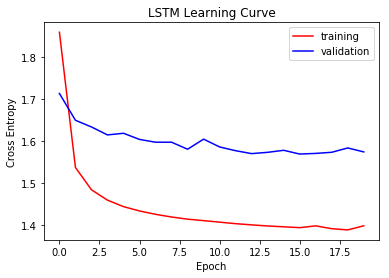

In [7]:
import matplotlib.pyplot as plt
t = np.arange(20)
p1 =plt.plot(LOSS,'r', label='training')
p2 = plt.plot(LOSS_,'b', label='validation')
plt.title('LSTM Learning Curve')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy')
plt.legend(loc='upper right') 
plt.show()

In [8]:
h_state=None
gen=[]
for i in range(1000):
    if(i<5):
        x_onehot = prime_encode[i].reshape(-1)
        x_onehot = (np.arange(68) == x_onehot[:,None]).astype(np.float32).reshape([1,1,68])
    b_x=Variable(torch.Tensor(x_onehot))
    b_x=b_x.cuda()
    prediction,h_state=rnn(b_x,h_state)
    #prediction=prediction.view(-1,68)
    h_state=Variable(h_state.data)
    h_state=h_state.cuda()
    prediction=Variable(prediction.data)
    prediction=prediction.cuda()
    #m=nn.Softmax()
    #prediction_w=m(prediction)
    word_encode=prediction.data.cpu().numpy()
    #tmp=np.argmax(word_encode.reshape(-1))
       # word_encode=word_encode.reshape(-1)
    word=[]
    
#     for i in range(5):
#         #tmp=np.argmax(word_encode[0,i,:])
#         P=softmax(word_encode[i,0,:].reshape(-1))
#         #print(P.shape)
#         tmp=np.random.choice(68,1,p=P)
#         word.append(tmp)
    P=softmax(word_encode.reshape(-1))
    tmp=np.random.choice(68,1,p=P)
    word.append(tmp)
    gen.append(word)
    word=np.array(word)
    x_onehot = word.reshape(-1)
    x_onehot = (np.arange(68) == x_onehot[:,None]).astype(np.float32).reshape([1,1,68])
# # x_onehot = word.reshape(-1)
# # x_onehot = (np.arange(68) == x_onehot[:,None]).astype(np.float32).reshape([5,1,68])
# # b_x=Variable(torch.Tensor(x_onehot))
# # b_x=b_x.cuda()
# # prediction,h_state=rnn(b_x,h_state)

gen=np.array(gen)
gen=gen.reshape(-1)
print(gen.shape)
word = [int_to_vocab[c] for c in gen]
print(word)
text_file = open("Output.txt", "w")
for i in range(len(word)):
    text_file.write(word[i])

text_file.close()

NameError: name 'prime_encode' is not defined